# **0 - HELPERS**

## 0.1 - Libraries

*Import required libraries*

In [1]:
# don't cache libraries (especially project library)
%load_ext autoreload
%autoreload 2

In [1]:
# setup and environment
import warnings
import os
from   pathlib import Path

# data manipulation
import re
import numpy as np
import pandas as pd

# images
from PIL import Image

# plots
import seaborn as sns
import matplotlib.pyplot as plt

# notebooks
from IPython.display import display, HTML

# time series
import pmdarima                    as     pm
from prophet                       import Prophet
from prophet.plot                  import plot_cross_validation_metric
from prophet.diagnostics           import cross_validation, performance_metrics
from statsmodels.tsa.seasonal      import seasonal_decompose
from statsmodels.tsa.stattools     import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model   import ARIMA

# machine learning
from sklearn.model_selection       import TimeSeriesSplit

# model tracking
import mlflow

/home/ds-gustavo-cunha/.pyenv/versions/omdena_sp_train/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 0.2 - Setup

*Define basic configurations*

In [3]:
#####################
# pandas dataframes #
#####################

# set cientific notation for pandas
pd.set_option(
    "display.float_format", "{:,.3f}".format
)  # used in some places like SeriesFormatter
pd.set_option(
    "display.precision", 3
)  # for regular formatting as well as scientific notation
pd.set_option(
    "styler.format.precision", 3
)  # The precision for floats and complex numbers
# don't truncate columns
pd.set_option("display.max_colwidth", 100)  # None for unlimited
# display all columns
pd.set_option("display.max_columns", None)
# display up to 100 rows
pd.set_option("display.max_rows", 100)
# display dimensions
pd.set_option("display.show_dimensions", True)
# define decimals and thousand separation
pd.set_option("styler.format.decimal", ",")
pd.set_option("styler.format.thousands", ".")

####################
# matplotlib plots #
####################

# set default plt figure size
plt.rcParams["figure.figsize"] = [10, 5]
# figure suptitle
plt.rcParams["figure.titlesize"] = "large"
plt.rcParams["figure.titleweight"] = "bold"
# set default plt font size
plt.rcParams["font.size"] = 24
# font weight
# plt.rcParams["font.weight"] = "bold"
# title location
plt.rcParams["axes.titlelocation"] = "left"
# title size
plt.rcParams["axes.titlesize"] = "large"
# title wight
plt.rcParams["axes.titleweight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
# spines
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
# axis labels
plt.rcParams["xaxis.labellocation"] = "left"
plt.rcParams["yaxis.labellocation"] = "top"
# figure layout
plt.rcParams["figure.autolayout"] = False
# save figures
plt.rcParams["savefig.dpi"] = 900
plt.rcParams["savefig.facecolor"] = "white"
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.format"] = "png"

# set fivethirtyeight pallete
plt.style.use("fivethirtyeight")

#####################
# jupyter notebooks #
#####################

# set cell size to be expanded
display(HTML("<style>.container { width:100% !important; }</style>"))

## 0.3 - Functions

*Define functions that will be used on the notebook*

In [4]:
def forecast_performance(forecast, actual):
    """
    Calculate forecasting performance given predicted values and real values.
    Calculated metrics are: MAPE, MPE, MAE, RMSE, RMSLE.

    Args
        forcast: a array-like object with predictions.
        actual: a array-like object with real values.

    Return
        a dict with keys as calculated metrics and values as their respective values
    """

    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    mpe = np.mean((forecast - actual)/actual)
    mae = np.mean(np.abs(forecast - actual))
    rmse = np.sqrt( np.mean( (forecast - actual)**2 ) )
    rmsle = np.sqrt( np.mean( ( np.log1p(forecast) / np.log1p(actual) )**2 ) )

    return {"mape":mape, "mpe":mpe, "mae": mae, 
            "rmse":rmse, "rmsle":rmsle}

## 0.4 - Constants

*Define reusuable constants*

In [5]:
# define the project root path that will be the "baseline" for all paths in the notebook
PROJECT_ROOT_PATH = Path.cwd().parent.parent.parent.parent
PROJECT_ROOT_PATH

PosixPath('/home/ds-gustavo-cunha/Projects/omdena_sp_train')

In [6]:
# define war data folder path
RAW_DATA_PATH = os.path.join(PROJECT_ROOT_PATH, "src", "tasks", "task_1_data_collection_preprocessing", "final_datasets")

# inspect folder
os.listdir(RAW_DATA_PATH)

['l01_pes_complete.csv',
 'README.md',
 'publiclines_pel_complete.csv',
 'alllines_pes_complete.csv',
 'publiclines_pel_21.csv',
 'l15_pes_complete.csv',
 'l02_pes_complete.csv',
 'publiclines_pel_22.csv',
 'publiclines_ptl_complete.csv',
 'l04_pes_complete.csv',
 'l03_pes_complete.csv',
 'l05_pes_complete.csv']

# **1 - DATA EXTRACTION**

## 1.1 - Entity Relationship Diagram

*Display Entity-Relationship Diagram to a better data understanding*

In [7]:
# To-DO

## 1.2 - Data Fields Description

*Describe available data in regard to database information*


#### **This folder contains the final datasets that should be used by the other teams**

- Check our Notion for the Feature's Schema. Does your dataset follow the schema?
- Follow this pattern for the file name: line_dataset_year where:
1. line = l + line number, with 2 digits. Check Notion for line's number. Ex.: l01
2. dataset: Where the data came from? Passengers transported by line = ptl, Passengers entry by line = pel, Passengers entry by station = pes. Ex.: l01_pel
3. year: Year with 2 digits. If the dataset is for the hole time span (2017-2023), use complete. Ex.: l1_pel_23 OR l3_pes_complete

#### **Github structure**

- Check for the folder **final_datasets**. This is the place for the final files.
- Follow this pattern for the file name: line_dataset_year where:
    1. line = l + line number, with 2 digits. If the dataset contains all the public lines or all the private lines, you should use: publiclines OR privatelines OR alllines (public + private)
        
        Ex.: **l01 or publiclines**
        
    2. dataset: Where the data came from? 
        1. Passengers transported by line = ptl,
        2. Passengers entry by line = pel,
        3. Passengers entry by station = pes. 
        
        Ex.: **l01_pel or publiclines_pel**
        
    3. year: Year with 2 digits. If the dataset is for the hole time span (2017-2023), use complete.
        
        Ex.: **l1_pel_23 OR l3_pes_complete OR publiclines_pes_complete**
        
    4. Exemples:
        - The dataset **l04_pel_22.csv** contains data for Yellow line, with Passengers entry by line for 2022
        - The dataset **publiclines_pes_complete** contains data for all the public lines (1,2,3 and 15), with passengers entry by line for all the years

#### Features - Schema

**Passenger entrance by line datasets**

- date - Month when the data was collected - datetime (yyyy-mm-dd)
- line - Subway line number - int
- total - Total of passengers that entered the station on that month - int
- business_day_mean - (MDU) Mean of passengers that entered the station on that month on business day - int
- saturday_mean - (MSA) Mean of passengers that entered the station on that month on saturdays - int
- sunday_mean - (MD0) Mean of passengers that entered the station on that month on sundays - int
- max - (MAX) Maximum of passengers entered on one day on that month - int

**Daily average passenger entrance by station on business days datasets**

- date - Month when the data was collected - datetime (yyyy-mm-dd)
- line - Subway line number - int
- station - Subway station - categorical?
- dpea - Daily average passenger entrance by station - int

**Passengers transported by line datasets**

- date - Month when the data was collected - datetime (yyyy-mm-dd)
- line - Subway line number - int
- total - Total of passengers transported by line on that month - int
- business_day_mean - (MDU) Mean of passengers transported on that month on business day - int
- saturday_mean - (MSA) Mean of passengers transported on that month on saturdays - int
- sunday_mean - (MD0) Mean of passengers transported on that month on sundays - int
- max - (MAX) Maximum of passengers transported on one day on that month - int

## 1.3 - Data Loading

*Load data from required files*

In [8]:
# define file to load data
FILE = os.path.join(RAW_DATA_PATH, "publiclines_ptl_complete.csv")

# read data from csv
df_extraction = pd.read_csv(
    filepath_or_buffer=FILE,
    parse_dates=["year_month"],
    infer_datetime_format=True
    #date_format="%Y-%m-%d"
    )

# inspect loaded dataset
display(
    df_extraction.dtypes,
    df_extraction
    )

/tmp/ipykernel_65498/2272420110.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_extraction = pd.read_csv(


year_month                  datetime64[ns]
line                                 int64
total                              float64
MDU (Business Days Mean)           float64
MSD (Saturdays Mean)               float64
MDO (Sundays Mean)                 float64
MAX (Daily Max)                    float64
Length: 7, dtype: object

year_month  line          total  MDU (Business Days Mean)  \
0   2018-08-01     3 38,679,000.000             1,440,000.000   
1   2018-08-01     1 37,775,000.000             1,420,000.000   
2   2018-08-01    15    516,000.000                22,000.000   
3   2018-08-01     2 18,164,000.000               701,000.000   
4   2018-08-01     5  7,220,000.000               309,000.000   
..         ...   ...            ...                       ...   
337 2023-04-01     2 14,544,000.000               649,000.000   
338 2023-04-01     4 15,070,570.000               661,450.000   
339 2023-04-01     5 11,792,220.000               510,810.000   
340 2023-04-01     1 25,545,000.000             1,091,000.000   
341 2023-04-01    15  2,827,000.000               124,000.000   

     MSD (Saturdays Mean)  MDO (Sundays Mean)  MAX (Daily Max)  
0             884,000.000         504,000.000    1,483,000.000  
1             832,000.000         446,000.000    1,466,000.000  
2                     NaN           2,000.000       23,000.000  
3             318,000.000         194,000.000      723,000.000  
4             176,000.000          85,000.000      322,000.000  
..                    ...                 ...              ...  
337           299,000.000         189,000.000      671,000.000  
338           338,300.000         201,580.000      701,710.000  
339           282,420.000         160,710.000      527,250.000  
340           639,000.000         375,000.000    1,130,000.000  
341            63,000.000          37,000.000      127,000.000  

[342 rows x 7 columns]

# **2 - DATA DESCRIPTION**

## 2.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [9]:
# create a restore point of the previous section
df_description = df_extraction.copy()

## 2.2 - Rename Columns

*Search for misleading or error-prone column names*

In [10]:
# check column names
df_description.columns

Index(['year_month', 'line', 'total', 'MDU (Business Days Mean)',
       'MSD (Saturdays Mean)', 'MDO (Sundays Mean)', 'MAX (Daily Max)'],
      dtype='object')

In [11]:
# rename columns to avoid spaces
df_description = df_description.rename(columns={
    "MDU (Business Days Mean)":"mdu_business_days_mean",
    "MSD (Saturdays Mean)": "msd_saturdays_mean",
    "MDO (Sundays Mean)": "mdo_sundays_Mean",
    "MAX (Daily Max)": "max_daily_max"
})

# check column names
df_description.columns

Index(['year_month', 'line', 'total', 'mdu_business_days_mean',
       'msd_saturdays_mean', 'mdo_sundays_Mean', 'max_daily_max'],
      dtype='object')

## 2.3 - Check Data Dimensions

*Check dataframe dimensions to know if pandas will be enough to handle such data size or we will need Big Data tools like Spark*

In [12]:
# check number of rows and columns
print( f'\
Dataframe has {df_description.shape[0]:,} \
rows and {df_description.shape[1]} columns' )

Dataframe has 342 rows and 7 columns


## 2.4 - Data Types

*Check if data types on dataframe makes sense according to database information*

In [13]:
# inspect dataframe types
display(
    df_description.dtypes,
    df_description.head(3)
    )

year_month                datetime64[ns]
line                               int64
total                            float64
mdu_business_days_mean           float64
msd_saturdays_mean               float64
mdo_sundays_Mean                 float64
max_daily_max                    float64
Length: 7, dtype: object

year_month  line          total  mdu_business_days_mean  msd_saturdays_mean  \
0 2018-08-01     3 38,679,000.000           1,440,000.000         884,000.000   
1 2018-08-01     1 37,775,000.000           1,420,000.000         832,000.000   
2 2018-08-01    15    516,000.000              22,000.000                 NaN   

   mdo_sundays_Mean  max_daily_max  
0       504,000.000  1,483,000.000  
1       446,000.000  1,466,000.000  
2         2,000.000     23,000.000  

[3 rows x 7 columns]

## 2.6 - Check Duplicated Rows

*Inspect duplicated rows and handle them properly*

In [14]:
# define dataframe granularity
df_grain = ["year_month","line"]

# check duplicated rows
print(
    f'{"*"*49}\n\n'
    f'There are {df_description.duplicated(keep=False).sum():,} \
duplicated rows [{df_description.duplicated(keep=False).mean()*100:.2f}%] based on all columns. \
Duplicated rows are double counted.'
    f'\n\n{"*"*49}\n\n'
    f'There are {df_description.duplicated(subset=df_grain, keep=False).sum():,} duplicated rows [{df_description.duplicated(subset=df_grain, keep=False).mean()*100:.2f}%] based on table granularity. \
Duplicated rows are double counted.'
    f'\n\n{"*"*49}'
)

*************************************************

There are 0 duplicated rows [0.00%] based on all columns. Duplicated rows are double counted.

*************************************************

There are 0 duplicated rows [0.00%] based on table granularity. Duplicated rows are double counted.

*************************************************


## 2.7 - Check Missing Values

*Inspect number and percentage of missing value per column to decide what to do with them*

In [15]:
#  get number of NAs
display(
    "Total of NAs",
    df_description.isna().sum(),
    "Percent of NAs",
    df_description.isna().mean()
)

'Total of NAs'

year_month                0
line                      0
total                     3
mdu_business_days_mean    3
msd_saturdays_mean        5
mdo_sundays_Mean          3
max_daily_max             3
Length: 7, dtype: int64

'Percent of NAs'

year_month               0.000
line                     0.000
total                    0.009
mdu_business_days_mean   0.009
msd_saturdays_mean       0.015
mdo_sundays_Mean         0.009
max_daily_max            0.009
Length: 7, dtype: float64

In [16]:
# inspect rows with NAs
df_description[df_description.isna().any(axis=1)]

year_month  line       total  mdu_business_days_mean  msd_saturdays_mean  \
2   2018-08-01    15 516,000.000              22,000.000                 NaN   
16  2018-10-01    15 498,000.000              22,000.000                 NaN   
114 2020-03-01    15         NaN                     NaN                 NaN   
122 2020-04-01    15         NaN                     NaN                 NaN   
131 2020-05-01    15         NaN                     NaN                 NaN   

     mdo_sundays_Mean  max_daily_max  
2           2,000.000     23,000.000  
16          4,000.000     25,000.000  
114               NaN            NaN  
122               NaN            NaN  
131               NaN            NaN  

[5 rows x 7 columns]

## 2.8 - Handle Missing Values

*Handle missing value for columns*

In [17]:
# No NA will be handled for this first iteration

## 2.9 - Descriptive Statistics

*Inspect some summary statistics for numerical columns*

In [18]:
# To-Do

### 2.9.4 - Investigate further:

*Variables to inspect the real meaning*

In [19]:
# ###################
# !!!!!!! NAs !!!!!!!
# ###################

# **3 - FEATURE ENGINEERING**

## 3.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [20]:
# create a restore point for the previous section dataframe
df_f_eng = df_description.copy()

# display
df_f_eng

year_month  line          total  mdu_business_days_mean  \
0   2018-08-01     3 38,679,000.000           1,440,000.000   
1   2018-08-01     1 37,775,000.000           1,420,000.000   
2   2018-08-01    15    516,000.000              22,000.000   
3   2018-08-01     2 18,164,000.000             701,000.000   
4   2018-08-01     5  7,220,000.000             309,000.000   
..         ...   ...            ...                     ...   
337 2023-04-01     2 14,544,000.000             649,000.000   
338 2023-04-01     4 15,070,570.000             661,450.000   
339 2023-04-01     5 11,792,220.000             510,810.000   
340 2023-04-01     1 25,545,000.000           1,091,000.000   
341 2023-04-01    15  2,827,000.000             124,000.000   

     msd_saturdays_mean  mdo_sundays_Mean  max_daily_max  
0           884,000.000       504,000.000  1,483,000.000  
1           832,000.000       446,000.000  1,466,000.000  
2                   NaN         2,000.000     23,000.000  
3           318,000.000       194,000.000    723,000.000  
4           176,000.000        85,000.000    322,000.000  
..                  ...               ...            ...  
337         299,000.000       189,000.000    671,000.000  
338         338,300.000       201,580.000    701,710.000  
339         282,420.000       160,710.000    527,250.000  
340         639,000.000       375,000.000  1,130,000.000  
341          63,000.000        37,000.000    127,000.000  

[342 rows x 7 columns]

## 3.2 - Hypothesis Testing List

*Define the list of hypotheses that will be validated during Exploratory Data Analysis (EDA)*

H1. **...**

H2. **...**

H3. **...**

H4. **...**

H5. **...**

## 3.3 - Feature Creation

*Create new features (columns) that can be meaningful for EDA and, especially, machine learning modelling.*

In [21]:
# No variable will be created for this first iteration

# **4 - DATA FILTERING**

## 4.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [22]:
# create a restore point for the previous section dataframe
df_filter = df_f_eng.copy()

# check dataframe
df_filter

year_month  line          total  mdu_business_days_mean  \
0   2018-08-01     3 38,679,000.000           1,440,000.000   
1   2018-08-01     1 37,775,000.000           1,420,000.000   
2   2018-08-01    15    516,000.000              22,000.000   
3   2018-08-01     2 18,164,000.000             701,000.000   
4   2018-08-01     5  7,220,000.000             309,000.000   
..         ...   ...            ...                     ...   
337 2023-04-01     2 14,544,000.000             649,000.000   
338 2023-04-01     4 15,070,570.000             661,450.000   
339 2023-04-01     5 11,792,220.000             510,810.000   
340 2023-04-01     1 25,545,000.000           1,091,000.000   
341 2023-04-01    15  2,827,000.000             124,000.000   

     msd_saturdays_mean  mdo_sundays_Mean  max_daily_max  
0           884,000.000       504,000.000  1,483,000.000  
1           832,000.000       446,000.000  1,466,000.000  
2                   NaN         2,000.000     23,000.000  
3           318,000.000       194,000.000    723,000.000  
4           176,000.000        85,000.000    322,000.000  
..                  ...               ...            ...  
337         299,000.000       189,000.000    671,000.000  
338         338,300.000       201,580.000    701,710.000  
339         282,420.000       160,710.000    527,250.000  
340         639,000.000       375,000.000  1,130,000.000  
341          63,000.000        37,000.000    127,000.000  

[342 rows x 7 columns]

## 4.2 Rows Filtering

*Remove rows with meaningless (or unimportant) data*

In [23]:
# No row will be removed for this first iteration

## 4.3 - Columns Filtering

*Remove auxiliary columns or columns that won't be available in the prediction moment*

In [24]:
# No row will be removed for this first iteration

# **5 - EXPLORATORY DATA ANALYSIS**

## 5.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [25]:
# create a restore point for the previous section dataframe
df_eda = df_filter.copy()

# check dataframe
df_eda

year_month  line          total  mdu_business_days_mean  \
0   2018-08-01     3 38,679,000.000           1,440,000.000   
1   2018-08-01     1 37,775,000.000           1,420,000.000   
2   2018-08-01    15    516,000.000              22,000.000   
3   2018-08-01     2 18,164,000.000             701,000.000   
4   2018-08-01     5  7,220,000.000             309,000.000   
..         ...   ...            ...                     ...   
337 2023-04-01     2 14,544,000.000             649,000.000   
338 2023-04-01     4 15,070,570.000             661,450.000   
339 2023-04-01     5 11,792,220.000             510,810.000   
340 2023-04-01     1 25,545,000.000           1,091,000.000   
341 2023-04-01    15  2,827,000.000             124,000.000   

     msd_saturdays_mean  mdo_sundays_Mean  max_daily_max  
0           884,000.000       504,000.000  1,483,000.000  
1           832,000.000       446,000.000  1,466,000.000  
2                   NaN         2,000.000     23,000.000  
3           318,000.000       194,000.000    723,000.000  
4           176,000.000        85,000.000    322,000.000  
..                  ...               ...            ...  
337         299,000.000       189,000.000    671,000.000  
338         338,300.000       201,580.000    701,710.000  
339         282,420.000       160,710.000    527,250.000  
340         639,000.000       375,000.000  1,130,000.000  
341          63,000.000        37,000.000    127,000.000  

[342 rows x 7 columns]

## 5.2 - Univariate Analysis

*Explore variables distributions*

In [26]:
# split dataset into types of features
df_eda_num = df_eda.select_dtypes(include=["number", "bool"])
df_eda_date = df_eda.select_dtypes(include=["datetime"])
df_eda_str = df_eda.select_dtypes(include=["object"])

# sanity check
assert df_eda_num.shape[1] + df_eda_date.shape[1] + df_eda_str.shape[1] == df_eda.shape[1], """Revise the previous split, something may be wrong!"""

### 5.2.1 - Numerical Columns

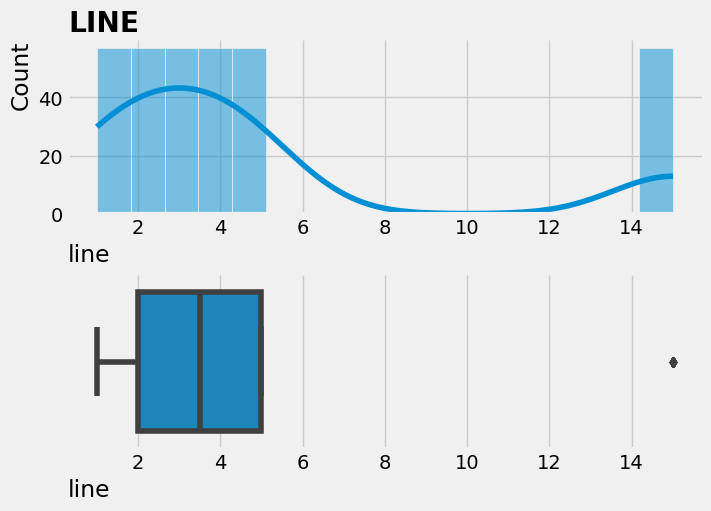

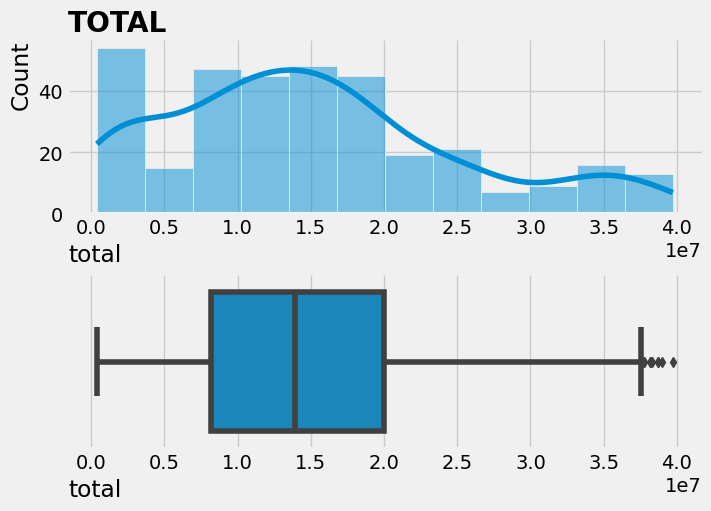

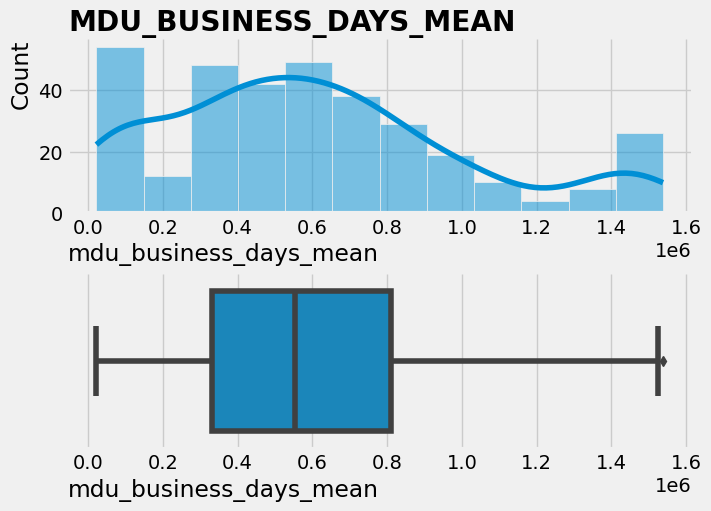

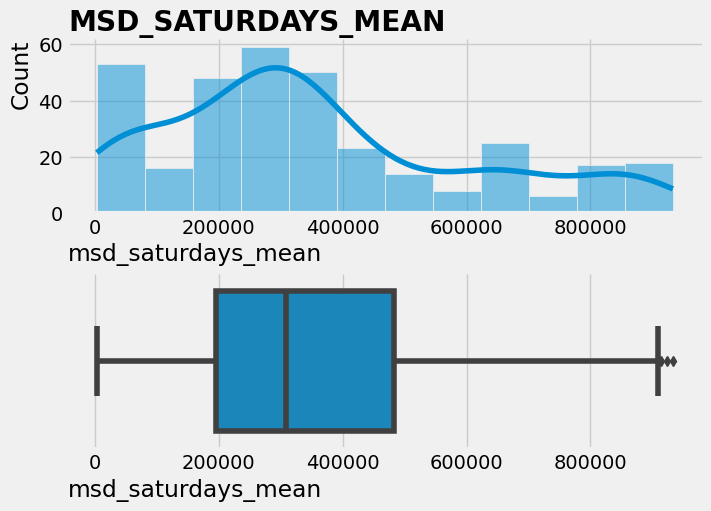

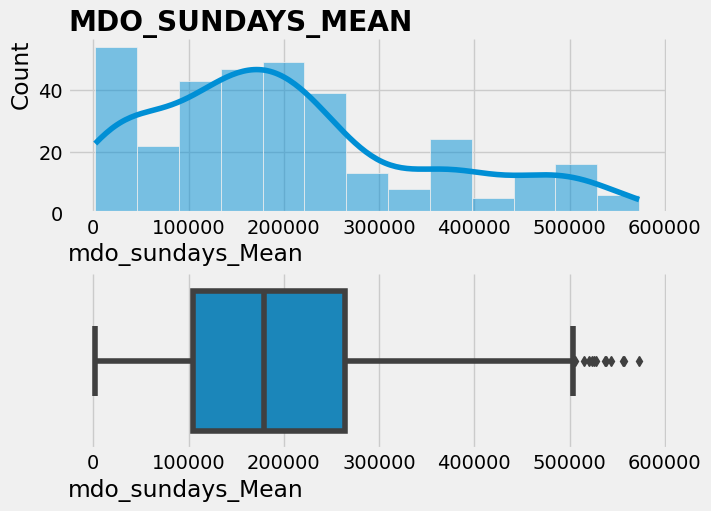

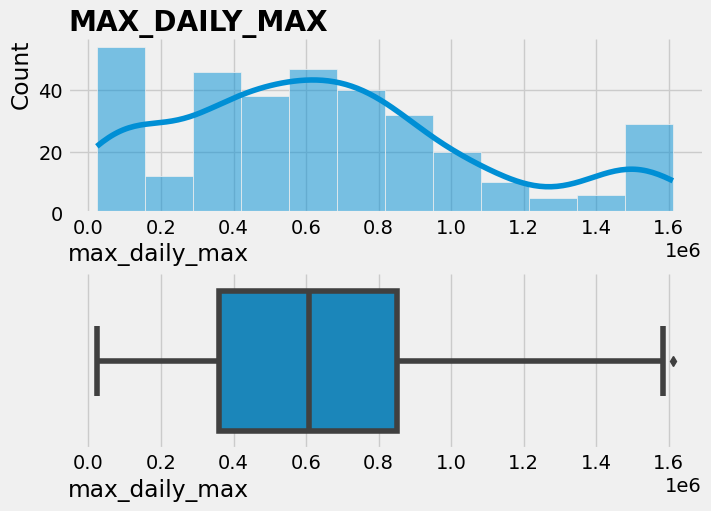

In [27]:
# iterate over numeric columns
for col in df_eda_num.columns.tolist():
    # create a figure object
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), constrained_layout=True)

    # plot histogram and boxplot
    sns.histplot(x=col, data=df_eda_num, kde=True, ax=axs[0])
    sns.boxplot(x=col, data=df_eda_num, ax=axs[1])
    # define plot details
    axs[0].set_title(f"{col.upper()}")
    plt.show()

### 5.2.2 - Categorical Columns

In [28]:
# iterate over categorical columns
for col in df_eda_str.columns.tolist():
    # create a figure object
    fig = plt.figure(figsize=(7, 5))

    # plot histogram and boxplot
    sns.barplot(x=col, data=df_eda_str)
    # define plot details
    plt.title(f"{col.upper()}")
    plt.show()

### 5.2.3 Datetime Columns

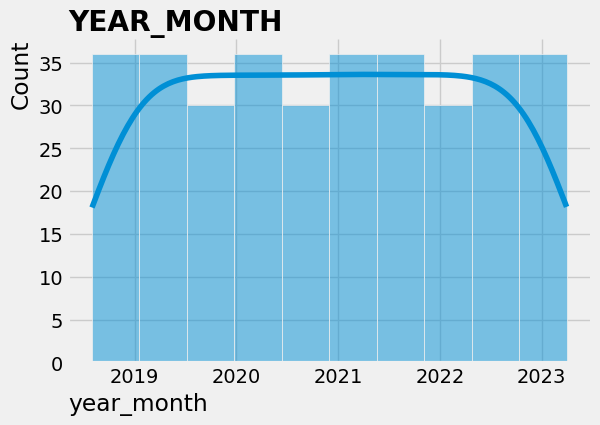

In [29]:
# iterate over numeric columns
for col in df_eda_date.columns.tolist():
    # create a figure object
    fig = plt.figure(figsize=(6, 4))
    # plot histogram and boxplot
    sns.histplot(x=col, data=df_eda_date, kde=True)
    # define plot details
    plt.title(f"{col.upper()}")
    plt.show()

## 5.3 - Bivariate Analysis

*Explore relationship between variables (in pairs)*

### 5.3.1 - Initial inspection

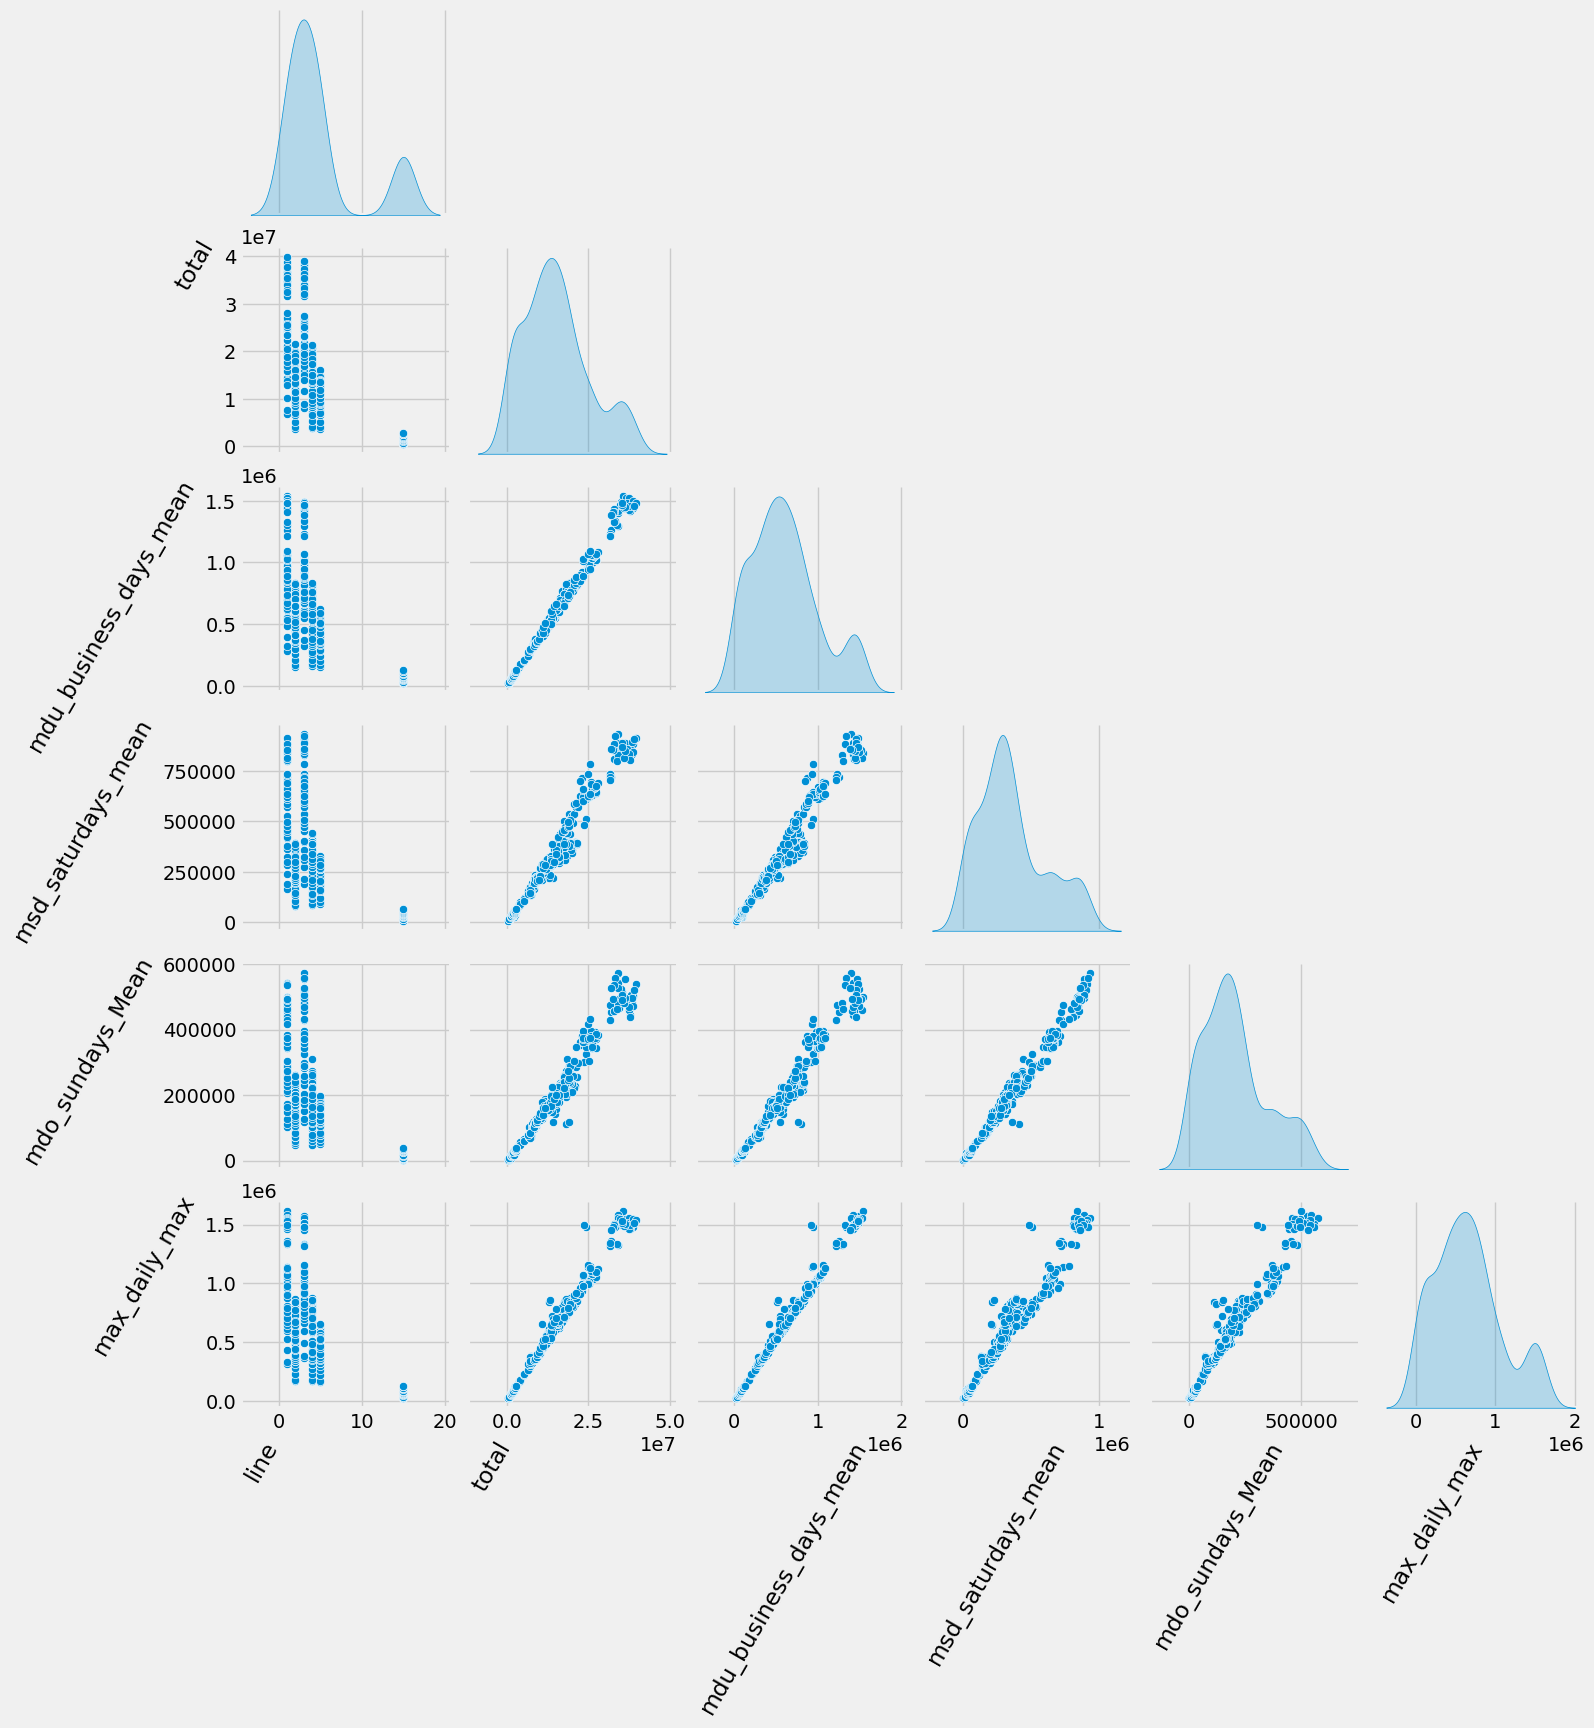

In [30]:
# plot pairplot
g = sns.pairplot(df_eda, diag_kind = "kde", corner=True);

# define plot details
for ax in g.axes.flatten():
    # try to rotate axis
    try:
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation = 60)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation = 60)
        # set y labels alignment
        ax.yaxis.get_label().set_horizontalalignment('right')
    # errors due to ax is None
    except:
        # skip
        pass

### 5.3.2 - Numerical variables

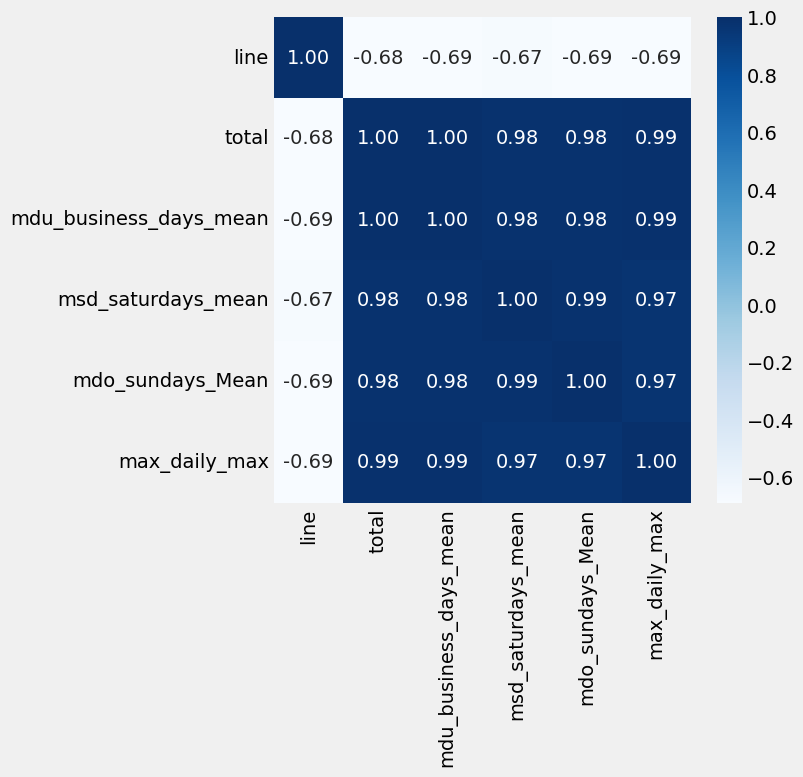

In [31]:
# calculate pearson correlation coefficient
correlation = df_eda_num.corr( method = 'spearman' )

# create figure and ax object
fig, ax = plt.subplots( figsize = (6, 6) )

# display heatmap of correlation on figure
sns.heatmap( correlation, annot = True, fmt=".2f", cmap="Blues")
plt.yticks( rotation = 0 );

### 5.3.3 - Categorical variables

In [32]:
# No categorical variable yet

## 5.4 - Business Hypothesis

*Validate all business hypothesis based on available data*

### **H1. ..**

### **H2. ..**

### **H3. ..**

### **H4. ..**

### **H5. ..**

## 5.5 - Time-series exploration

*Explore time-series variables*

In [33]:
df_eda

year_month  line          total  mdu_business_days_mean  \
0   2018-08-01     3 38,679,000.000           1,440,000.000   
1   2018-08-01     1 37,775,000.000           1,420,000.000   
2   2018-08-01    15    516,000.000              22,000.000   
3   2018-08-01     2 18,164,000.000             701,000.000   
4   2018-08-01     5  7,220,000.000             309,000.000   
..         ...   ...            ...                     ...   
337 2023-04-01     2 14,544,000.000             649,000.000   
338 2023-04-01     4 15,070,570.000             661,450.000   
339 2023-04-01     5 11,792,220.000             510,810.000   
340 2023-04-01     1 25,545,000.000           1,091,000.000   
341 2023-04-01    15  2,827,000.000             124,000.000   

     msd_saturdays_mean  mdo_sundays_Mean  max_daily_max  
0           884,000.000       504,000.000  1,483,000.000  
1           832,000.000       446,000.000  1,466,000.000  
2                   NaN         2,000.000     23,000.000  
3           318,000.000       194,000.000    723,000.000  
4           176,000.000        85,000.000    322,000.000  
..                  ...               ...            ...  
337         299,000.000       189,000.000    671,000.000  
338         338,300.000       201,580.000    701,710.000  
339         282,420.000       160,710.000    527,250.000  
340         639,000.000       375,000.000  1,130,000.000  
341          63,000.000        37,000.000    127,000.000  

[342 rows x 7 columns]

*************************************************
	TOTAL
*************************************************


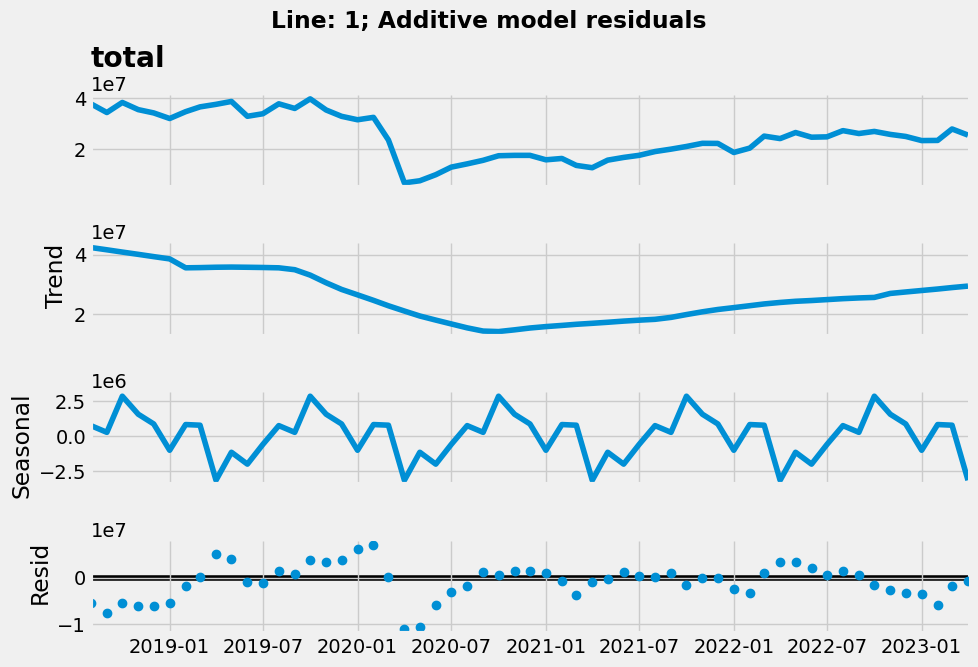

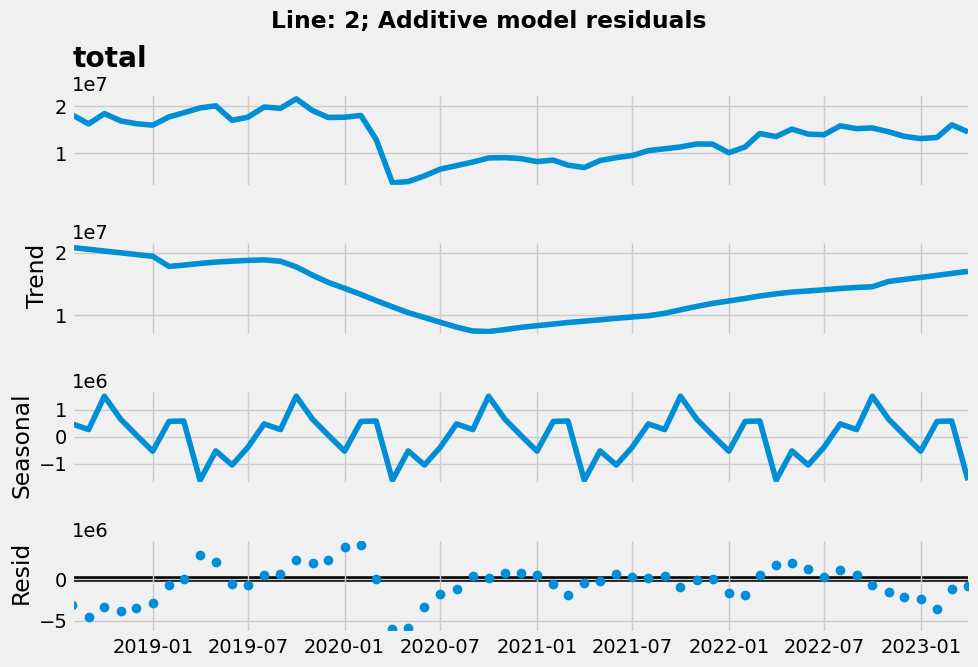

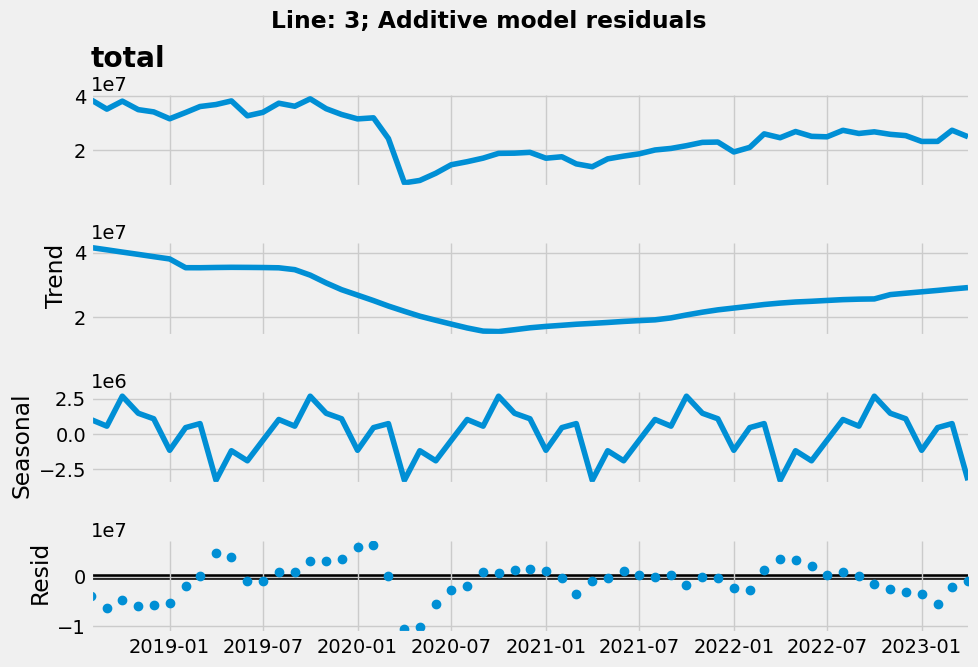

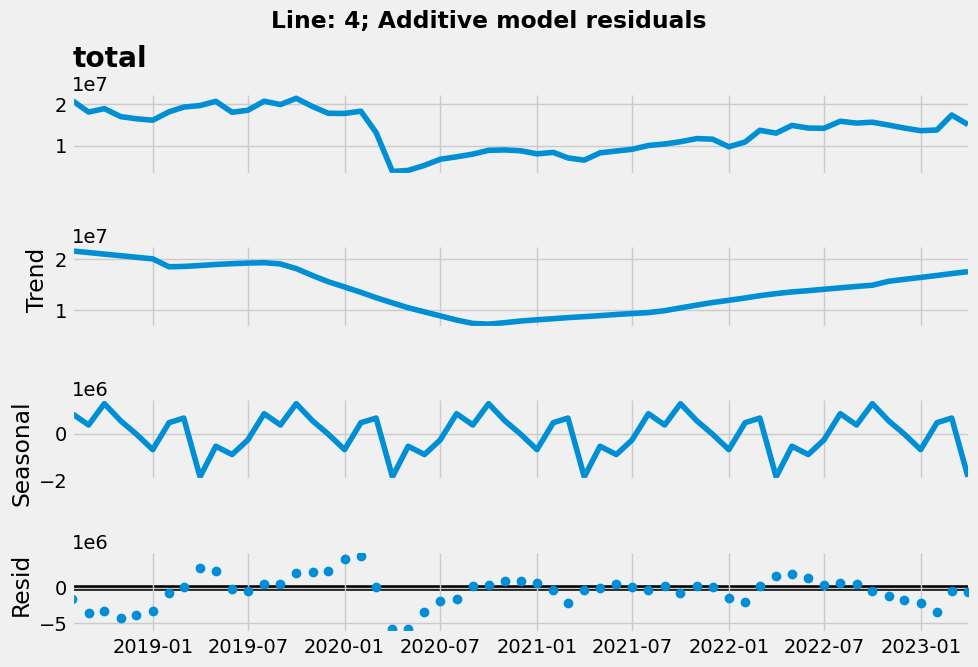

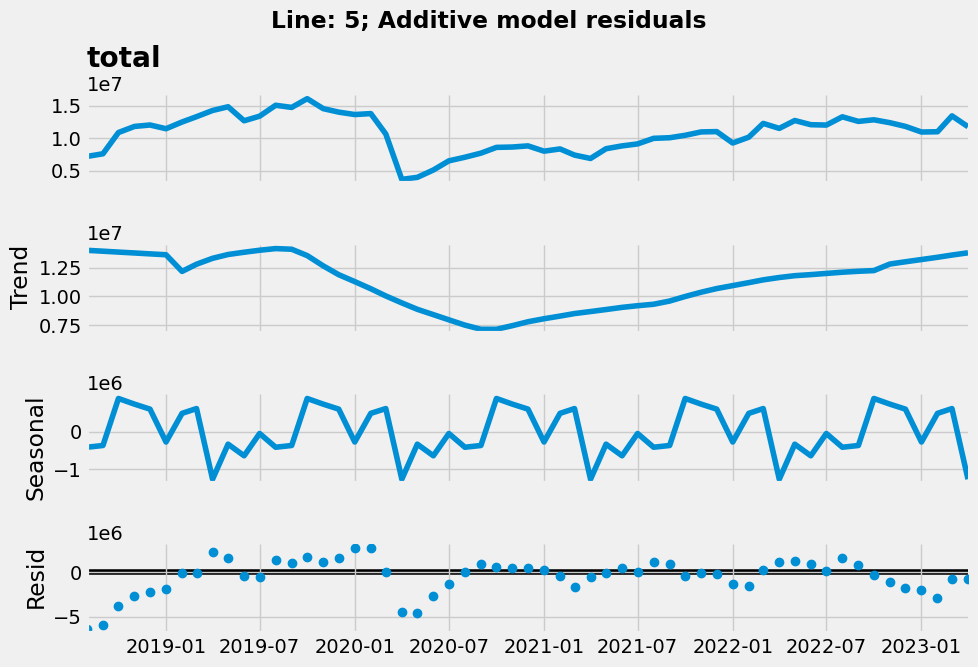

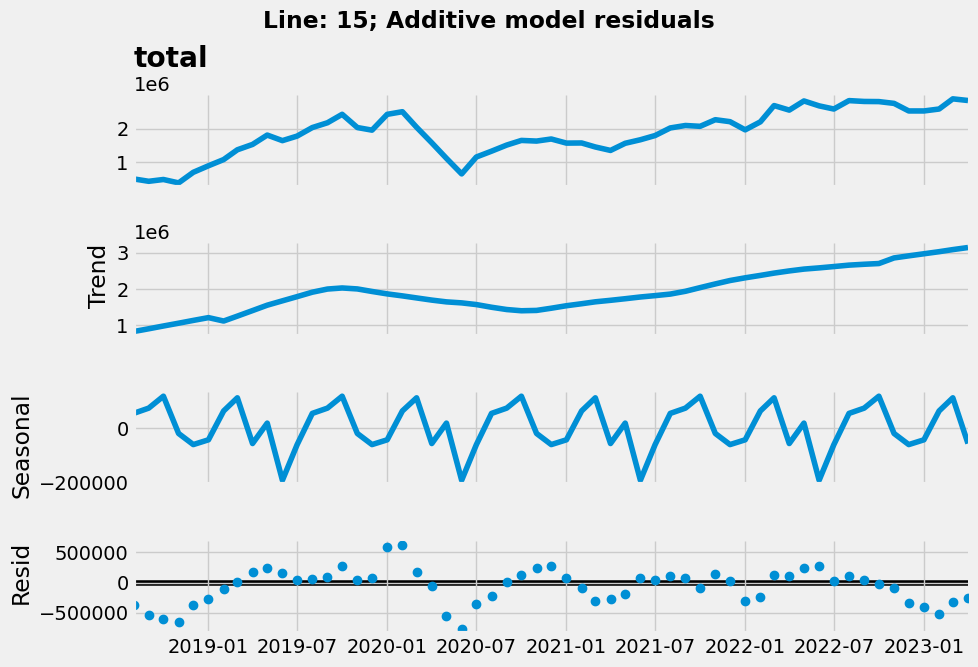

*************************************************
	MDU_BUSINESS_DAYS_MEAN
*************************************************


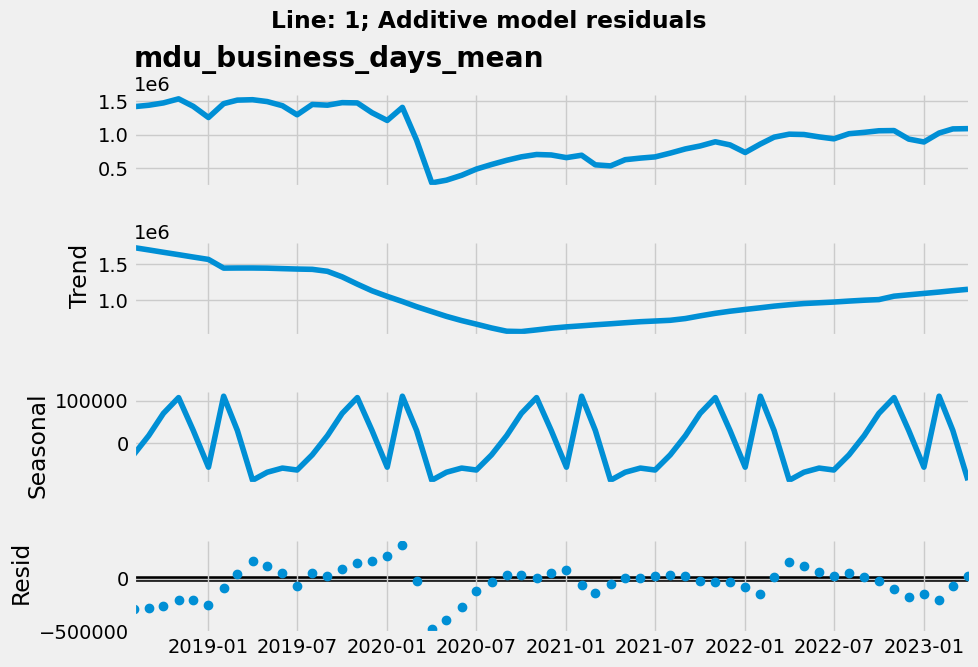

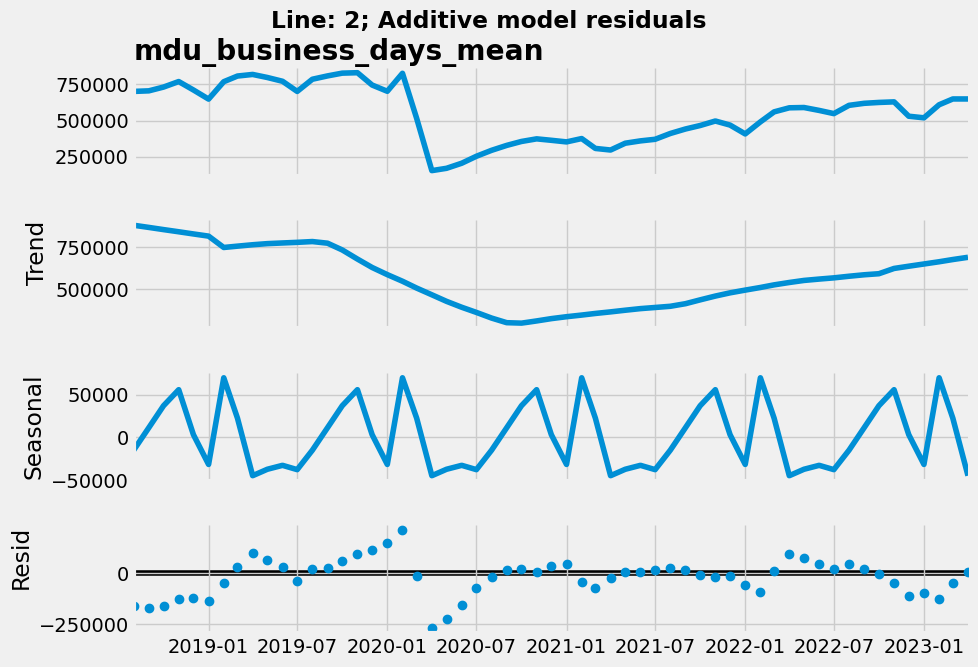

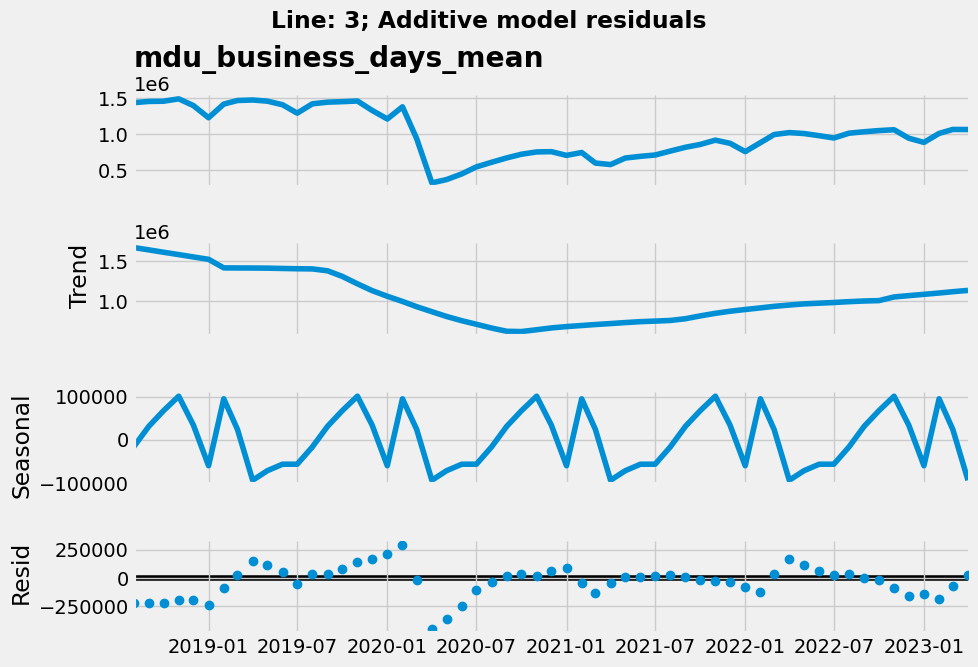

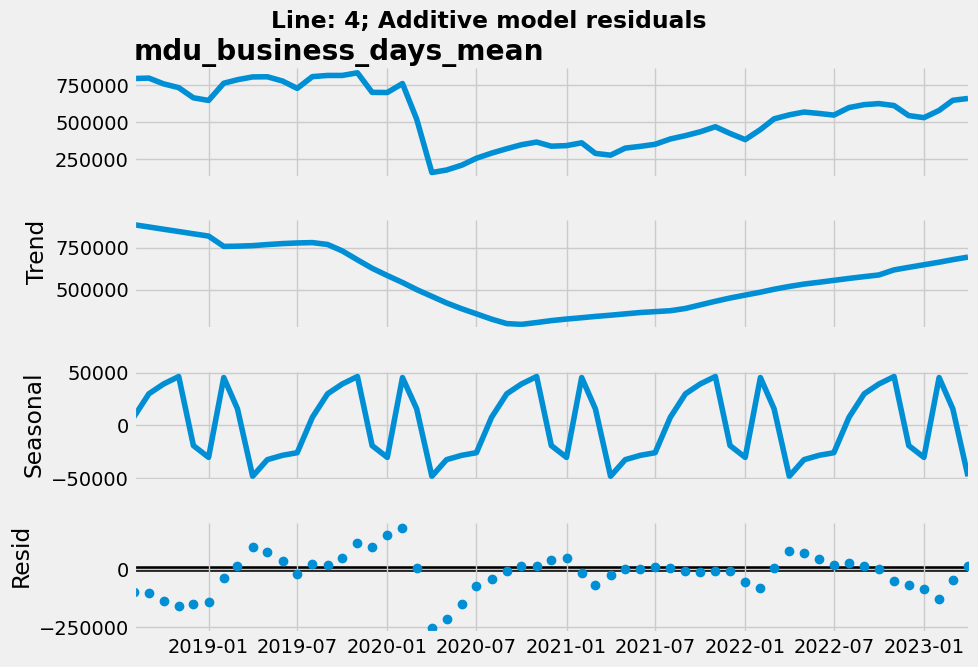

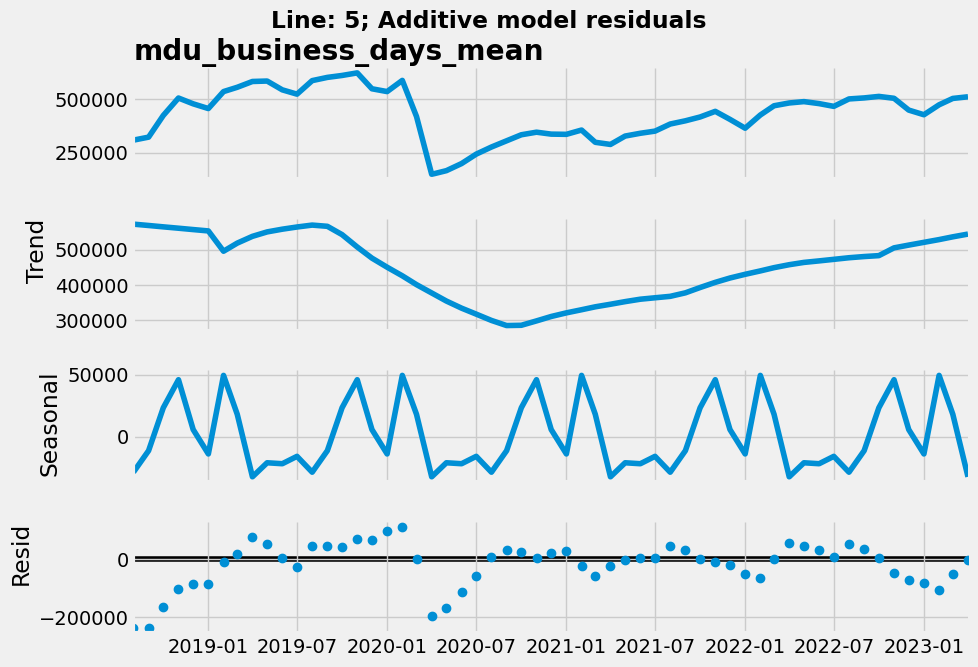

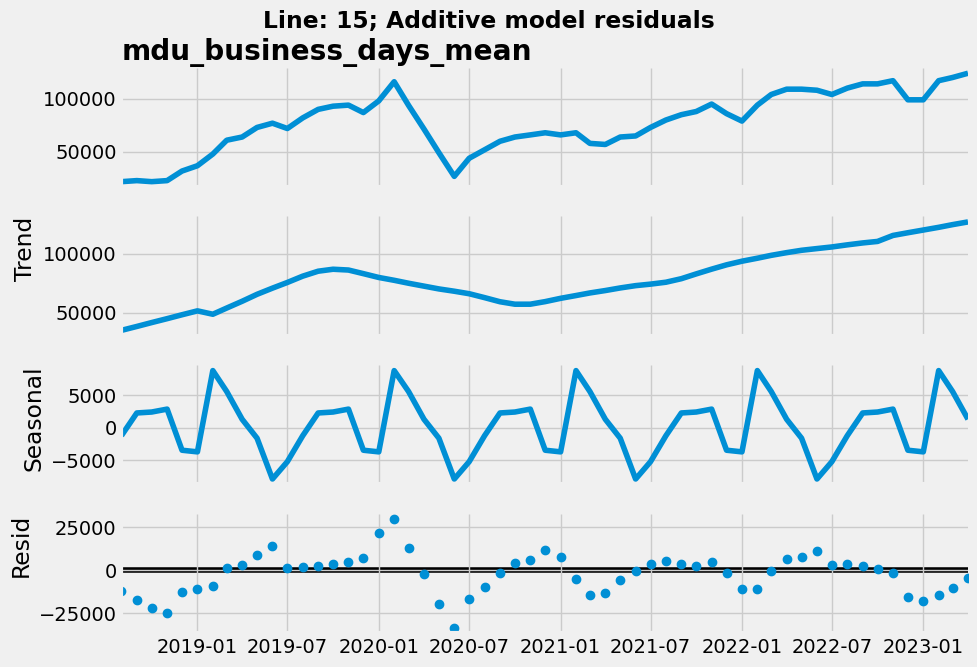

*************************************************
	MSD_SATURDAYS_MEAN
*************************************************


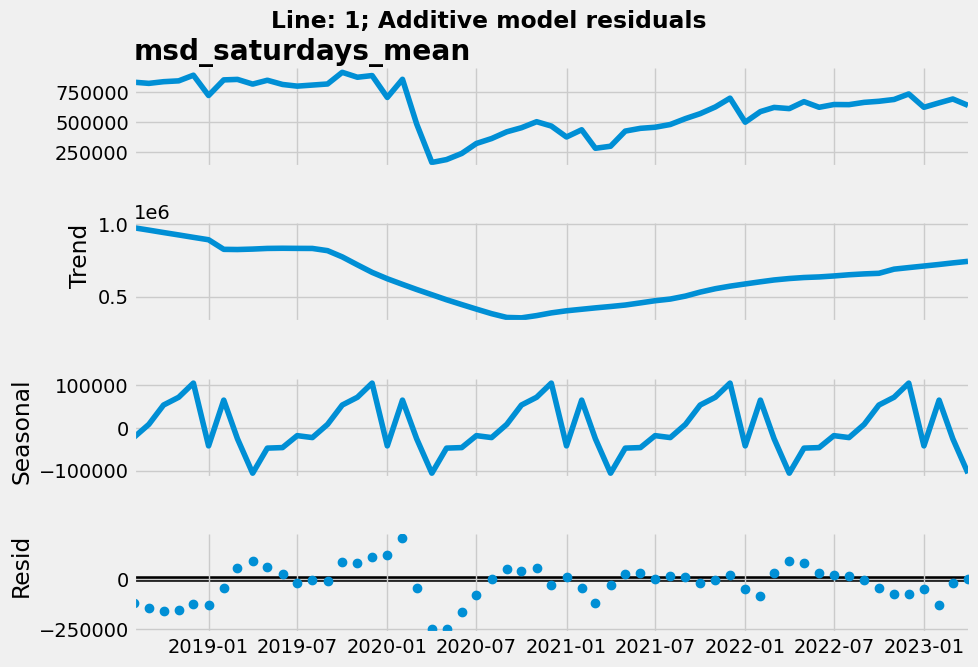

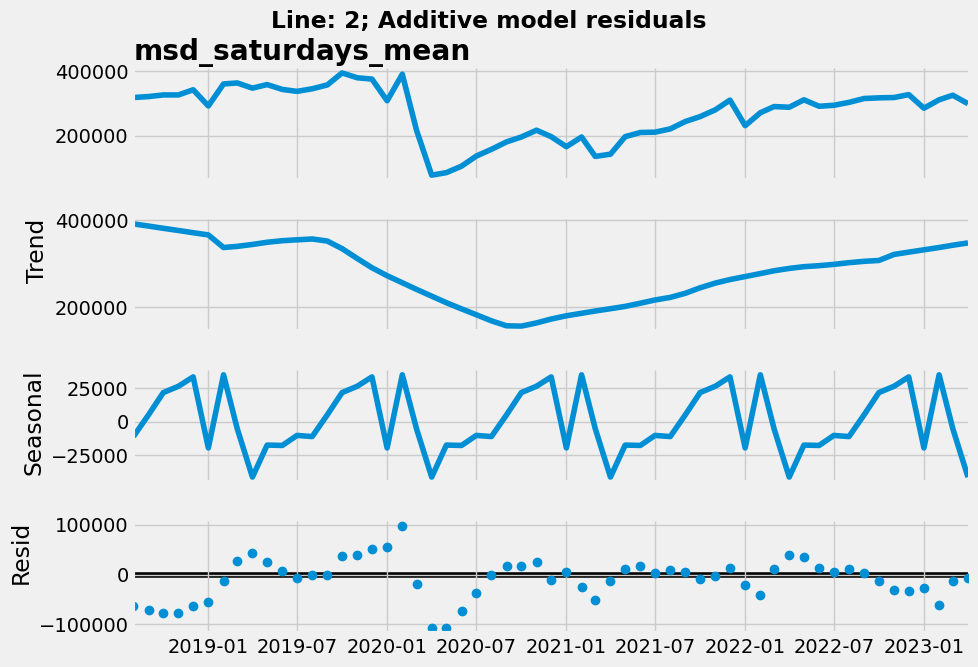

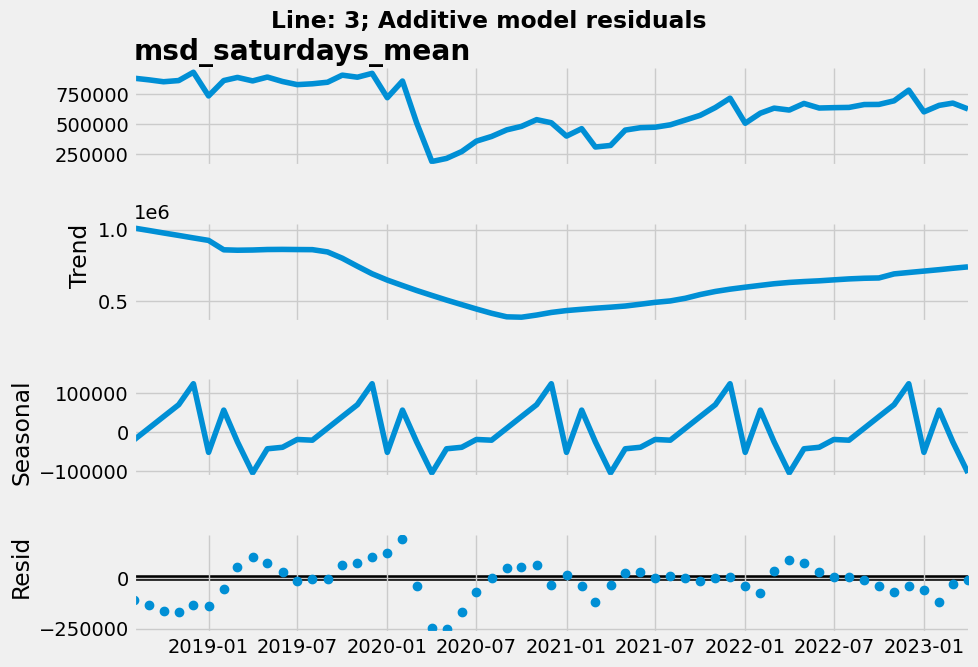

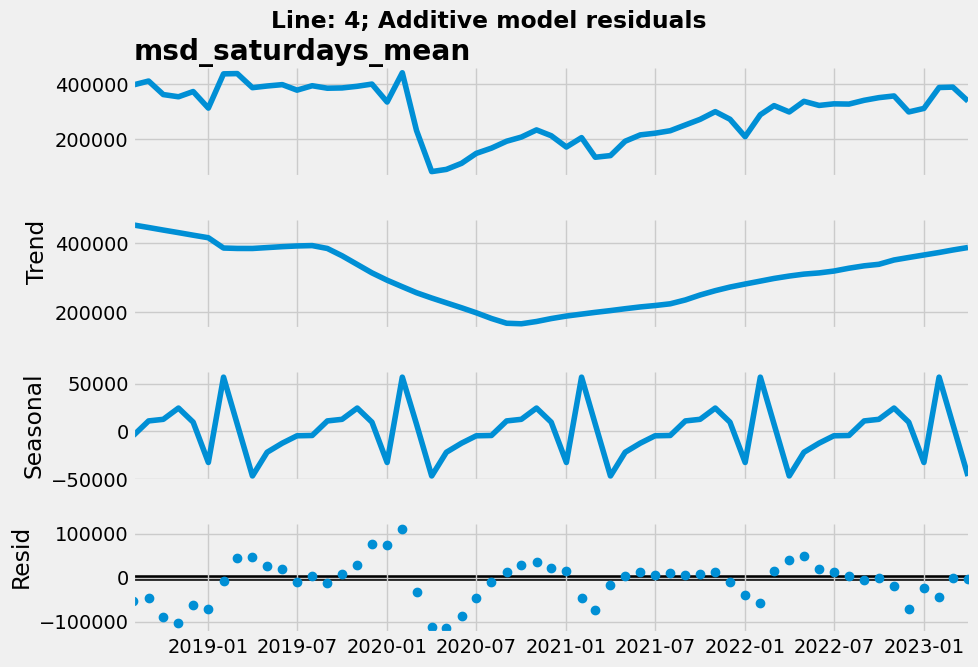

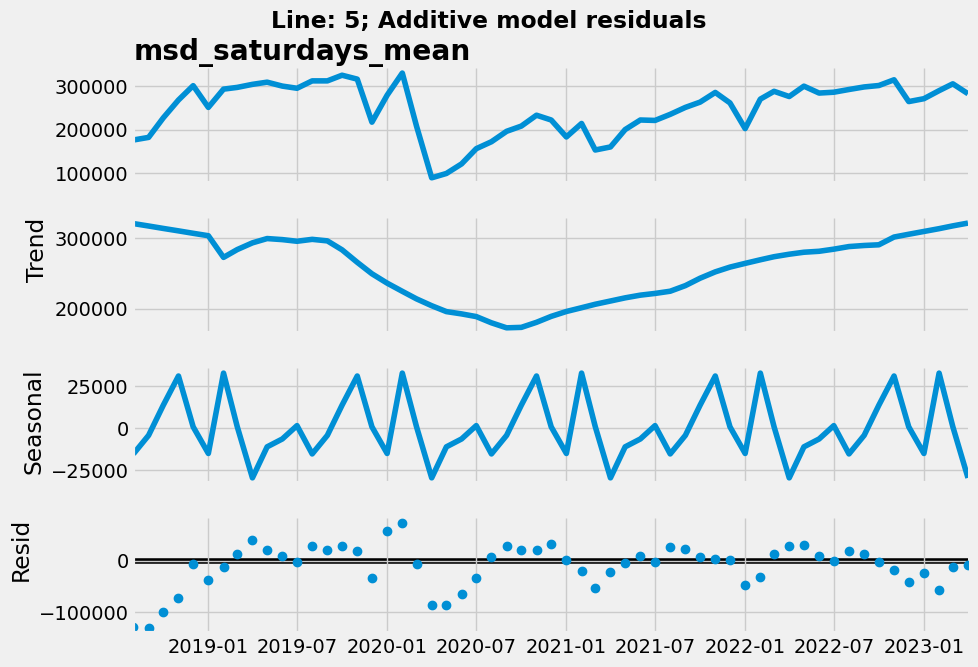

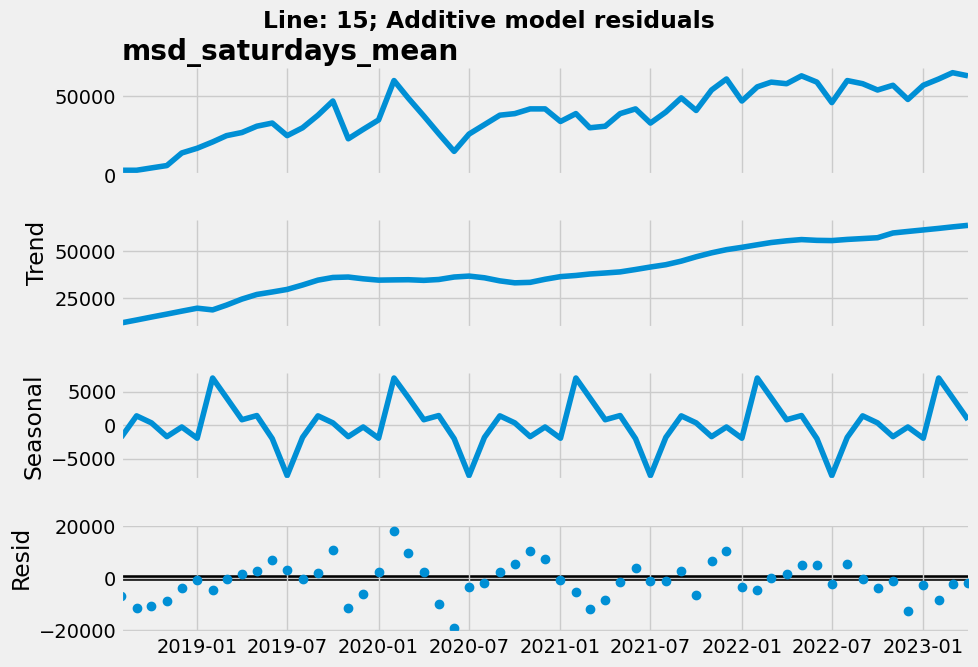

*************************************************
	MDO_SUNDAYS_MEAN
*************************************************


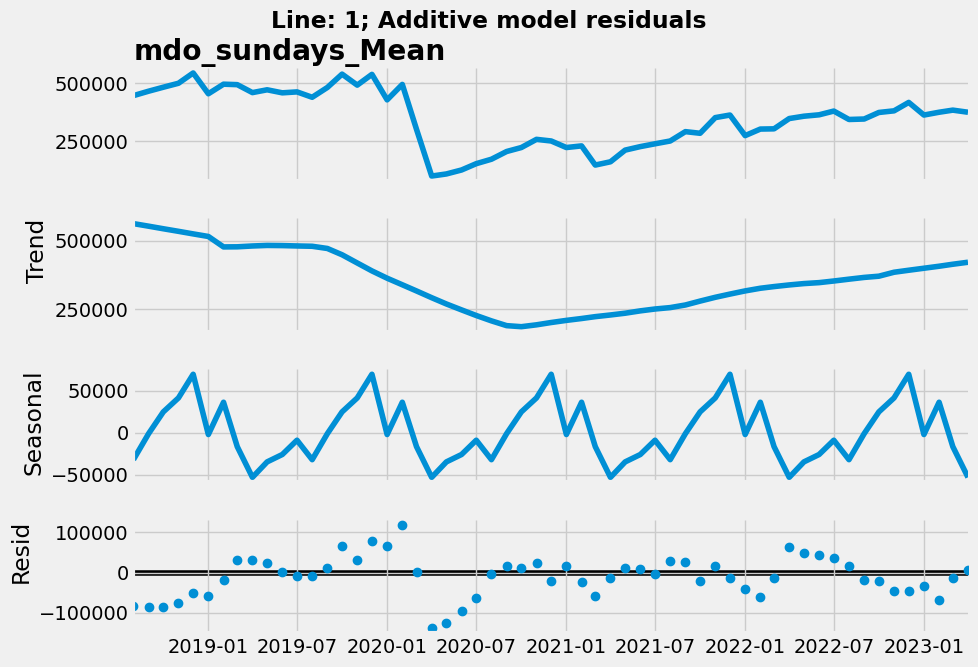

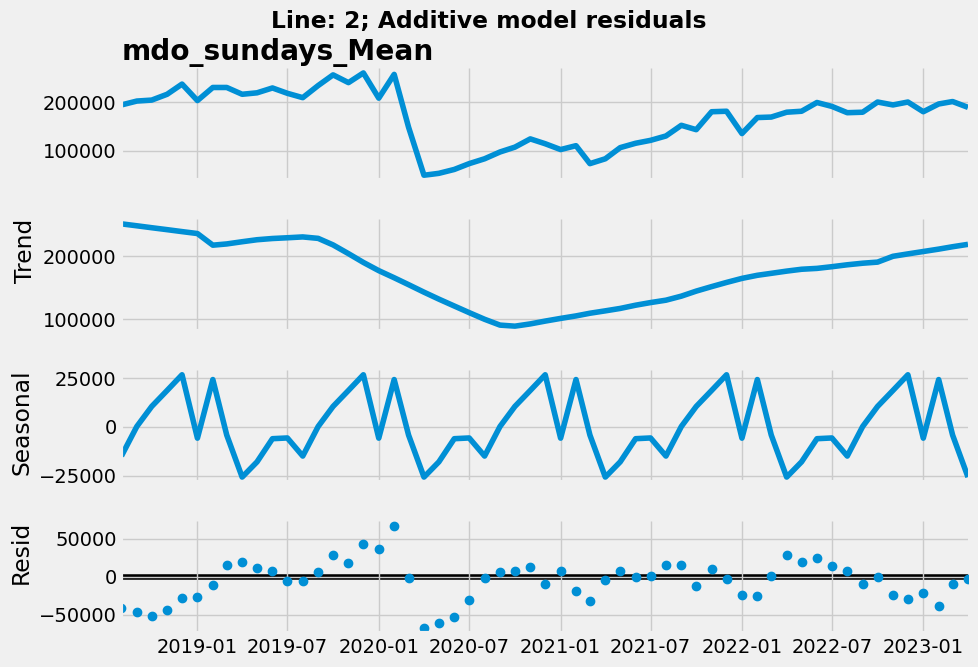

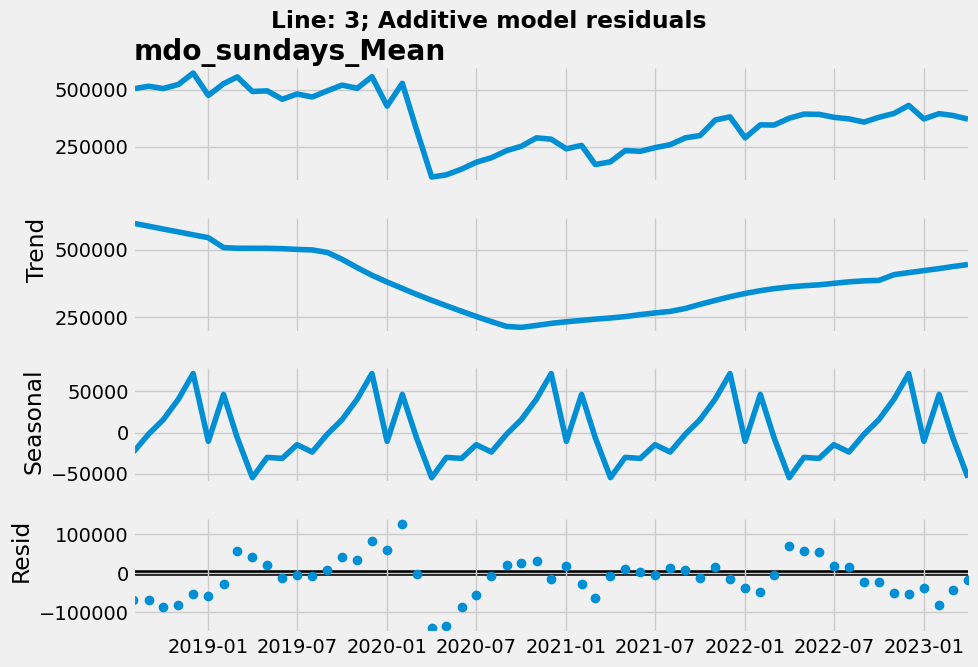

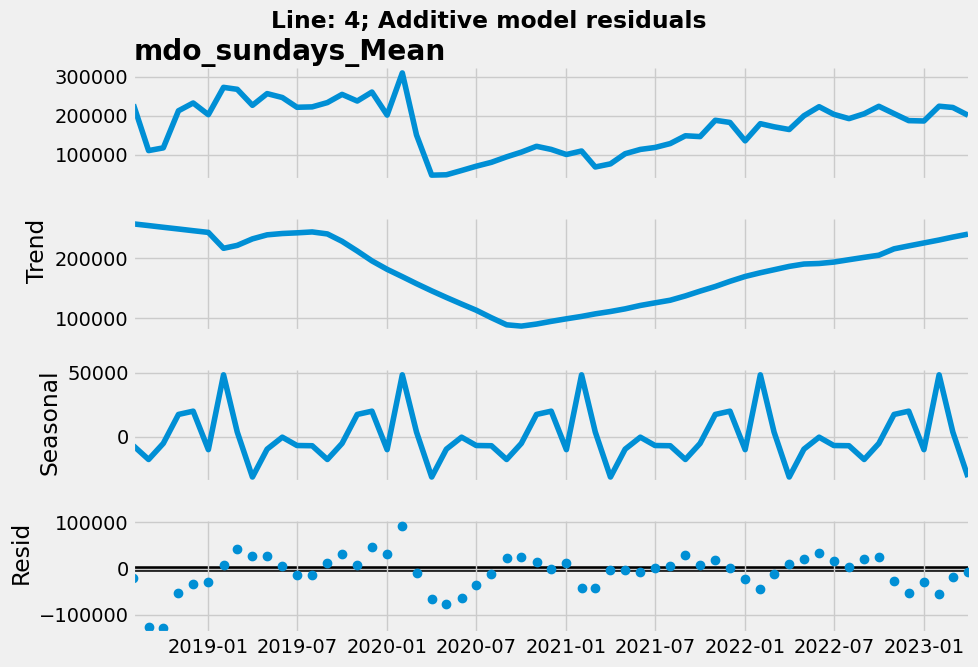

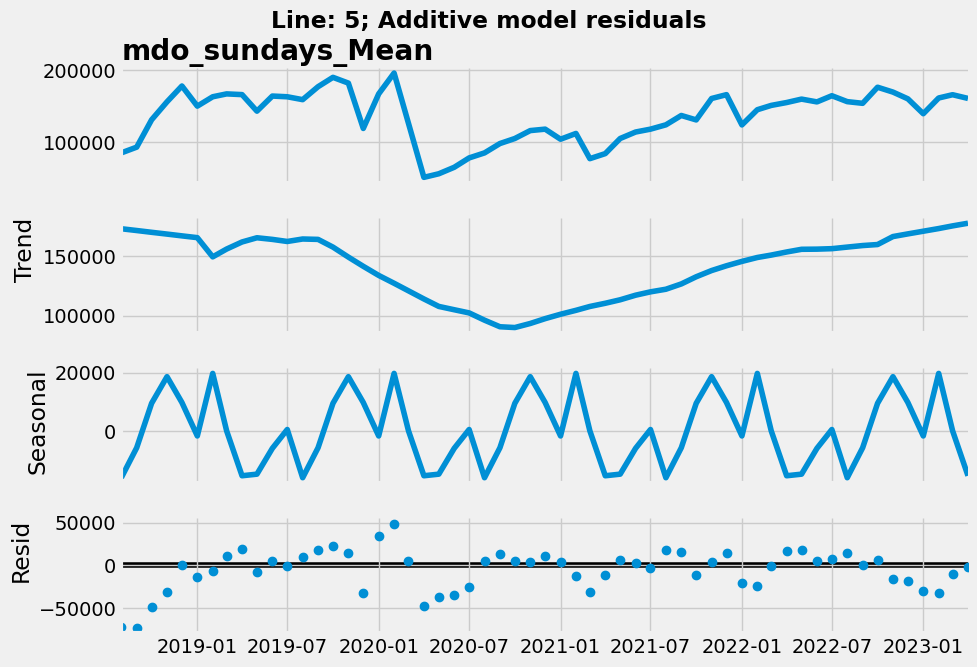

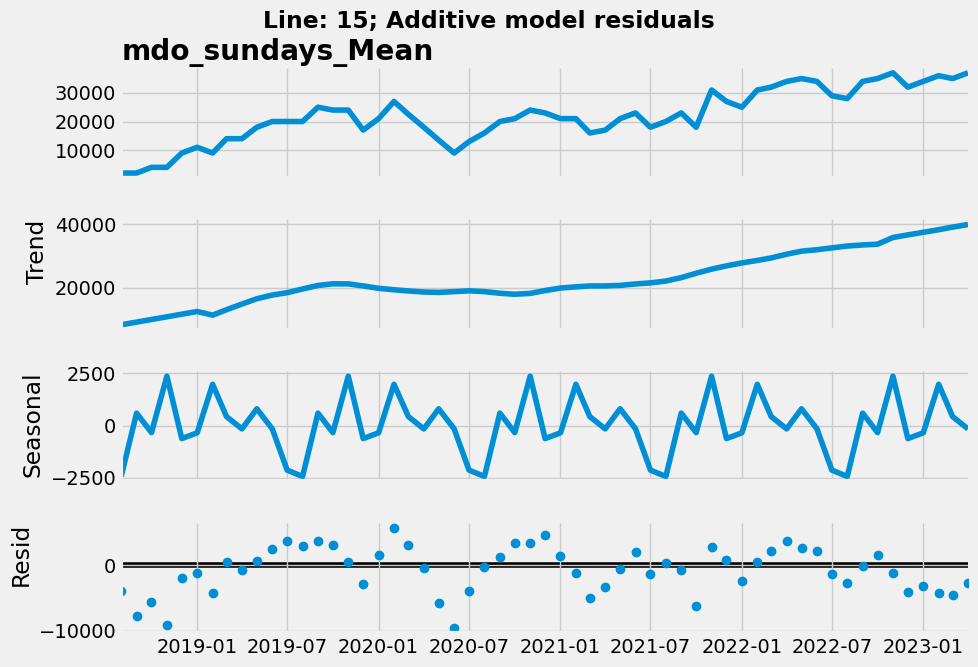

*************************************************
	MAX_DAILY_MAX
*************************************************


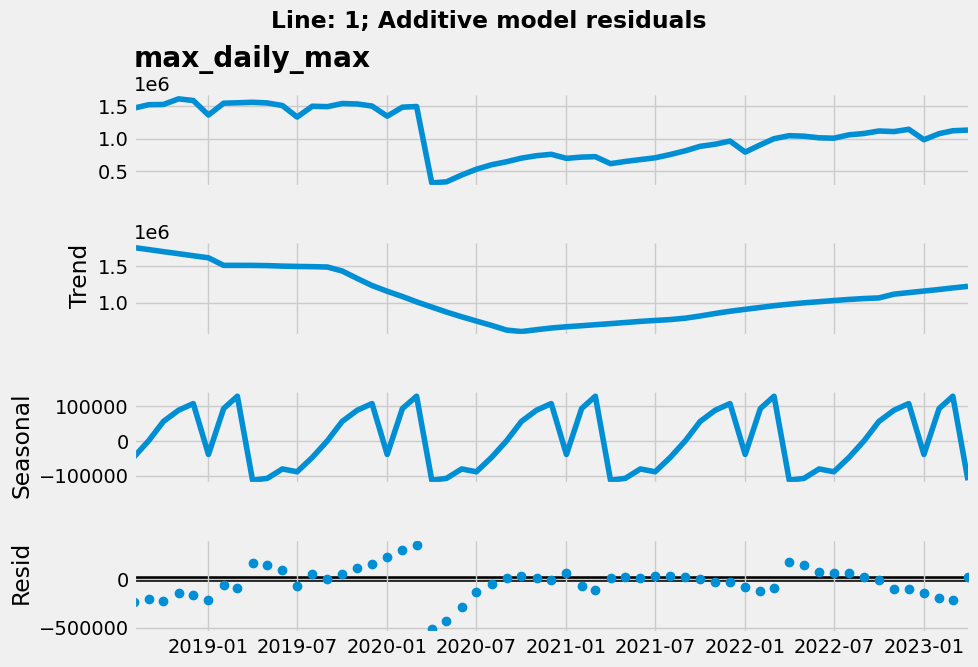

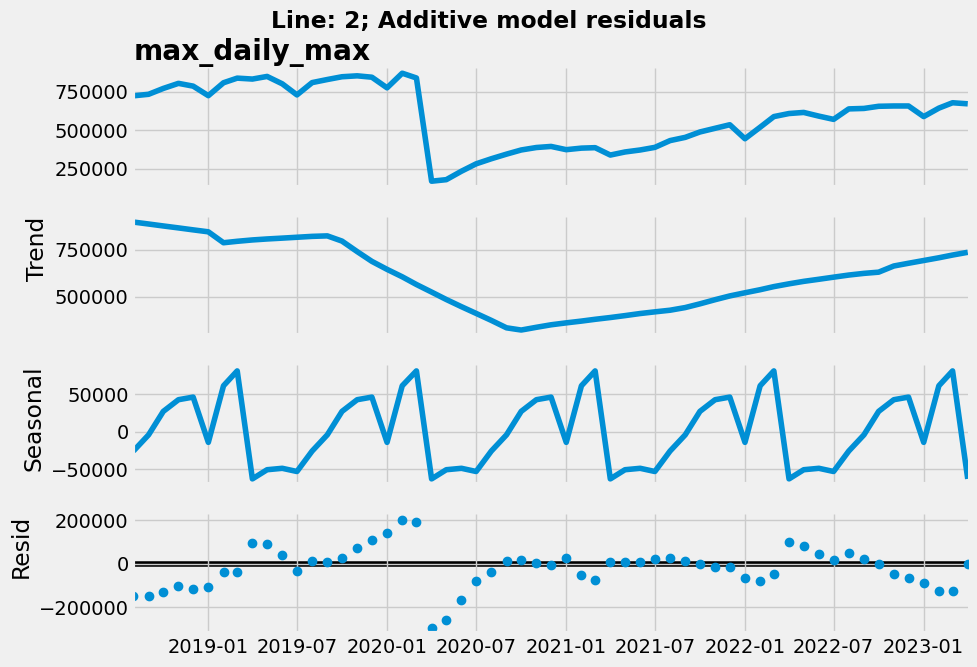

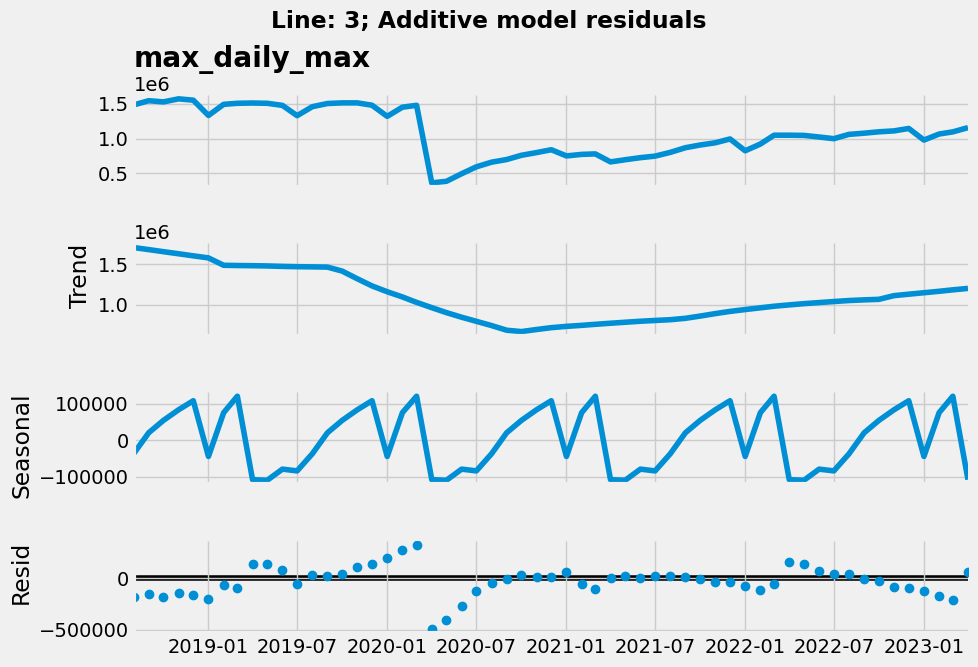

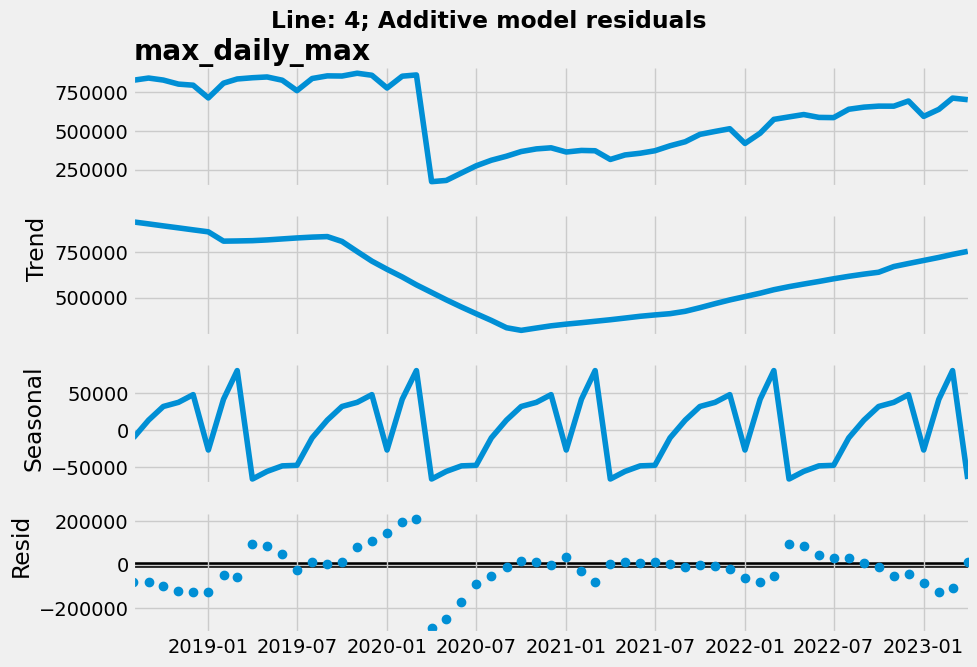

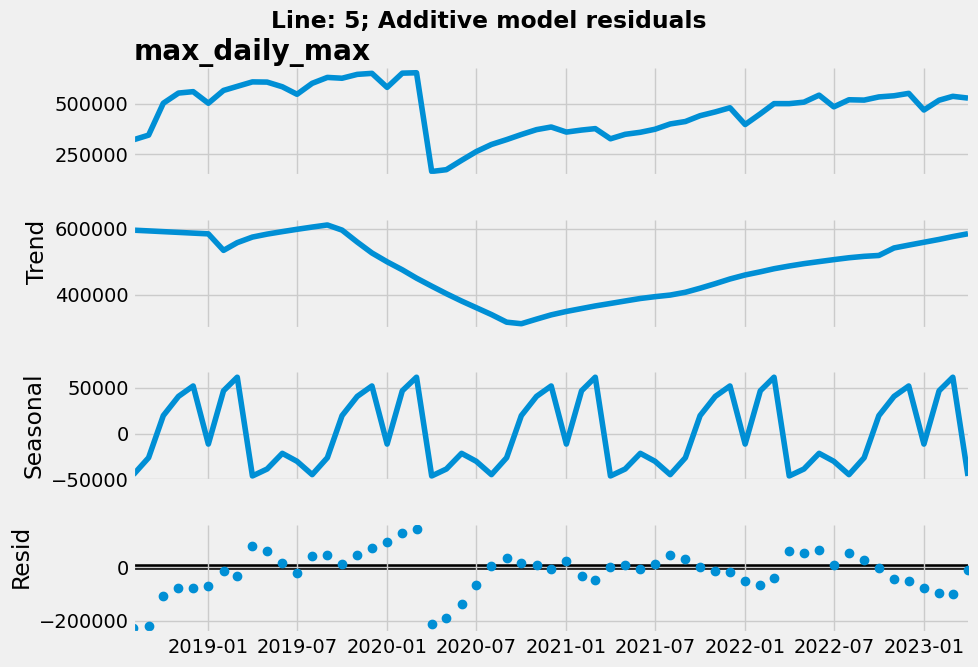

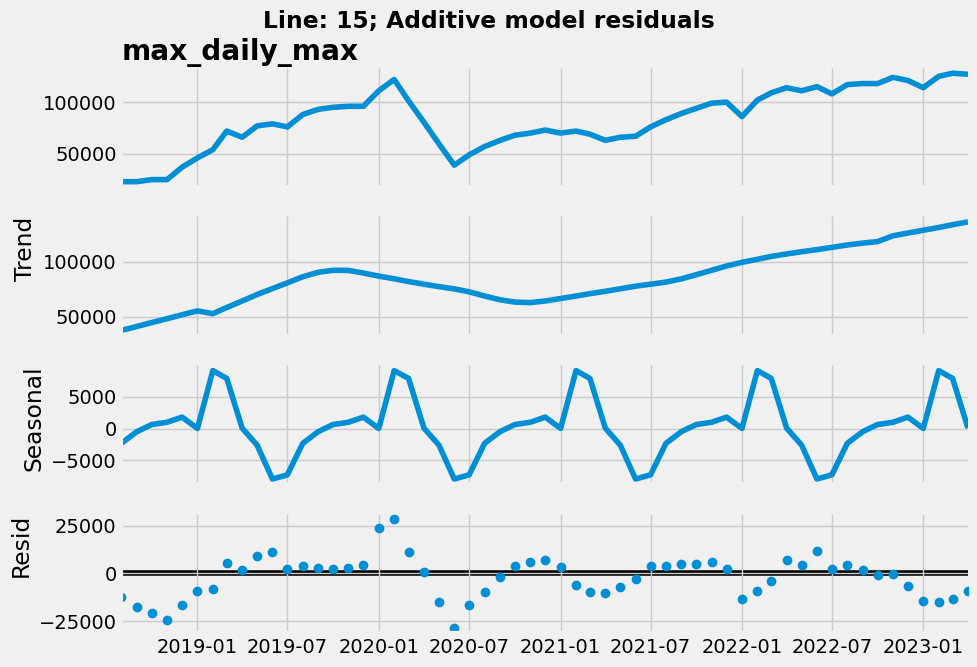

In [34]:
# iterate over columns
#for col in ["msd_saturdays_mean"]:#df_eda.columns[2:].tolist():
for col in df_eda.columns[2:].tolist():

    # chekc if column is not numeric
    if not pd.api.types.is_numeric_dtype(df_eda[col].dtypes):
        # skip to next column
        continue

    # print report
    print(
        f"{'*'*49}\n"
        f"\t{col.upper()}\n"
        f"{'*'*49}"
    )

    # get unique lines
    unique_lines = df_eda["line"].unique().tolist()
    unique_lines.sort()
    
    # # iterate over available lines
    # for line in [15]:#unique_lines:
    # iterate over available lines
    for line in unique_lines:

        # filter to only a single line
        df_line = df_eda.loc[df_eda["line"] == line, ["year_month", col]]

        # create a new dataframe with year_month as index,
        # dropping year_month from column
        # and filling any missing data with linear interpolation
        df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
        # fill any missing data at the begining of dataset (not able to interpolate)
        # with backfill
        df_line = df_line.fillna(method="backfill")

        # Additive Decomposition (y = Trend + Seasonal + Residuals)
        result_add = seasonal_decompose(df_line[col], model='additive', extrapolate_trend = "freq")
        # # Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
        # result_mul = seasonal_decompose(df_line[col], model='multiplicative', extrapolate_trend = "freq")

        # define plot details
        result_add.plot()
        g = plt.gcf()
        g.set_size_inches(10, 7)
        g.suptitle(f"Line: {line}; Additive model residuals\n")
        plt.show()


# **6 - DATA PREPARATION**

## 6.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [35]:
# create a restore point for the previous section dataframe
df_prep = df_eda.copy()

# check dataframe
df_prep

year_month  line          total  mdu_business_days_mean  \
0   2018-08-01     3 38,679,000.000           1,440,000.000   
1   2018-08-01     1 37,775,000.000           1,420,000.000   
2   2018-08-01    15    516,000.000              22,000.000   
3   2018-08-01     2 18,164,000.000             701,000.000   
4   2018-08-01     5  7,220,000.000             309,000.000   
..         ...   ...            ...                     ...   
337 2023-04-01     2 14,544,000.000             649,000.000   
338 2023-04-01     4 15,070,570.000             661,450.000   
339 2023-04-01     5 11,792,220.000             510,810.000   
340 2023-04-01     1 25,545,000.000           1,091,000.000   
341 2023-04-01    15  2,827,000.000             124,000.000   

     msd_saturdays_mean  mdo_sundays_Mean  max_daily_max  
0           884,000.000       504,000.000  1,483,000.000  
1           832,000.000       446,000.000  1,466,000.000  
2                   NaN         2,000.000     23,000.000  
3           318,000.000       194,000.000    723,000.000  
4           176,000.000        85,000.000    322,000.000  
..                  ...               ...            ...  
337         299,000.000       189,000.000    671,000.000  
338         338,300.000       201,580.000    701,710.000  
339         282,420.000       160,710.000    527,250.000  
340         639,000.000       375,000.000  1,130,000.000  
341          63,000.000        37,000.000    127,000.000  

[342 rows x 7 columns]

## 6.2 - Remove variables that won't be available in the production environment

*Remove variables that model can use on production to make predictions*

In [36]:
# No need for this first iteration

## 6.3 - Train-Validation-Test split

*Split dataframe into training, validation and test dataset*

In [37]:
# No need for this first iteration

## 6.4 - Scale numeric features

*Scale numeric feature to make modelling "easier" for ML models*

### 6.4.1 - Standard Scaler

In [38]:
# No need for this first iteration

### 6.4.2 - Min-Max Scaler

In [39]:
# No need for this first iteration

### 6.4.3 - Robust Scaler

In [40]:
# No need for this first iteration

### 6.4.4 - Discretization

In [41]:
# No need for this first iteration

## 6.5 - Encode categorical features

*Encode categorical feature to make modelling possible for ML models*

### 6.5.1 - One-Hot Encodingm

In [42]:
# No need for this first iteration

### 6.5.2 - Ordinal Encoding

In [43]:
# No need for this first iteration

### 6.5.3 - Target Encoding

In [44]:
# No need for this first iteration

## 6.6 - Response variable transformation

*Transform target variable (e.g. log, sqrt, etc) to make modelling "easier" for ML models*

In [45]:
# No need for this first iteration

## 6.7 - Cyclic variables transformation

*Transform cyclic variables (e.g. days of week, months in year, etc) with a sin and cos functions*

In [46]:
# No need for this first iteration

## 6.8 - Double-check preparation

*Double-check the prepared dataset to make sure it is as expected*

In [47]:
# No need for this first iteration

# **7 - FEATURE SELECTION**

## 7.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [48]:
# create a restore point for the previous section dataframe
df_f_selection = df_prep.copy()

# check dataframe
df_f_selection

year_month  line          total  mdu_business_days_mean  \
0   2018-08-01     3 38,679,000.000           1,440,000.000   
1   2018-08-01     1 37,775,000.000           1,420,000.000   
2   2018-08-01    15    516,000.000              22,000.000   
3   2018-08-01     2 18,164,000.000             701,000.000   
4   2018-08-01     5  7,220,000.000             309,000.000   
..         ...   ...            ...                     ...   
337 2023-04-01     2 14,544,000.000             649,000.000   
338 2023-04-01     4 15,070,570.000             661,450.000   
339 2023-04-01     5 11,792,220.000             510,810.000   
340 2023-04-01     1 25,545,000.000           1,091,000.000   
341 2023-04-01    15  2,827,000.000             124,000.000   

     msd_saturdays_mean  mdo_sundays_Mean  max_daily_max  
0           884,000.000       504,000.000  1,483,000.000  
1           832,000.000       446,000.000  1,466,000.000  
2                   NaN         2,000.000     23,000.000  
3           318,000.000       194,000.000    723,000.000  
4           176,000.000        85,000.000    322,000.000  
..                  ...               ...            ...  
337         299,000.000       189,000.000    671,000.000  
338         338,300.000       201,580.000    701,710.000  
339         282,420.000       160,710.000    527,250.000  
340         639,000.000       375,000.000  1,130,000.000  
341          63,000.000        37,000.000    127,000.000  

[342 rows x 7 columns]

## 7.2 - Logist regression coefficients

In [49]:
# No need for this first iteration

## 7.3 - Random forest feature importance

In [50]:
# No need for this first iteration

## 7.4 - Boruta algorithm

In [51]:
# No need for this first iteration

## 7.5 - Mutual information

In [52]:
# No need for this first iteration

# **8 - ML MODEL TRAINING**

## 8.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [53]:
# create a restore point for the previous section dataframe
df_train = df_f_selection.copy()

# check dataframe
df_train

year_month  line          total  mdu_business_days_mean  \
0   2018-08-01     3 38,679,000.000           1,440,000.000   
1   2018-08-01     1 37,775,000.000           1,420,000.000   
2   2018-08-01    15    516,000.000              22,000.000   
3   2018-08-01     2 18,164,000.000             701,000.000   
4   2018-08-01     5  7,220,000.000             309,000.000   
..         ...   ...            ...                     ...   
337 2023-04-01     2 14,544,000.000             649,000.000   
338 2023-04-01     4 15,070,570.000             661,450.000   
339 2023-04-01     5 11,792,220.000             510,810.000   
340 2023-04-01     1 25,545,000.000           1,091,000.000   
341 2023-04-01    15  2,827,000.000             124,000.000   

     msd_saturdays_mean  mdo_sundays_Mean  max_daily_max  
0           884,000.000       504,000.000  1,483,000.000  
1           832,000.000       446,000.000  1,466,000.000  
2                   NaN         2,000.000     23,000.000  
3           318,000.000       194,000.000    723,000.000  
4           176,000.000        85,000.000    322,000.000  
..                  ...               ...            ...  
337         299,000.000       189,000.000    671,000.000  
338         338,300.000       201,580.000    701,710.000  
339         282,420.000       160,710.000    527,250.000  
340         639,000.000       375,000.000  1,130,000.000  
341          63,000.000        37,000.000    127,000.000  

[342 rows x 7 columns]

## 8.2 - Metrics

*Define the metric of success and the health metrics*

**Metrics**
- Mean Error (ME)
- Mean Percentage Error (MPE)
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Root Mean Squared Logarithmix Error (RMSLE)

**Main metric**
- MAPE

**Health metrics**
- MPE
- MAE
- RMSE
- RMSLE

## 8.3 - Baseline model

*Check the performance metrics with a dummy model to get the baseline metric*

In [54]:
# TO-DO

## 8.4 - ML models

*Get performance metrics of ML model with cross-validation*

### ARMA

ADF test for stationarity on feature TOTAL and line 1
	p-value for residuals on additive decomposition       0.001
	p-value for residuals on multiplicative decomposition 0.000


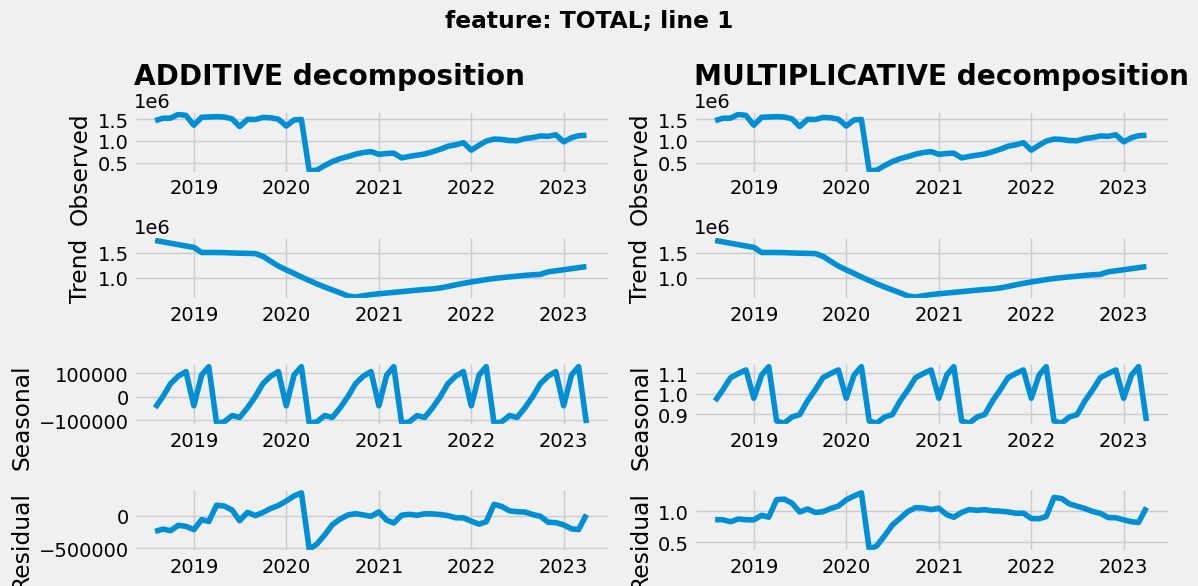

ADF test for stationarity on feature TOTAL and line 2
	p-value for residuals on additive decomposition       0.000
	p-value for residuals on multiplicative decomposition 0.000


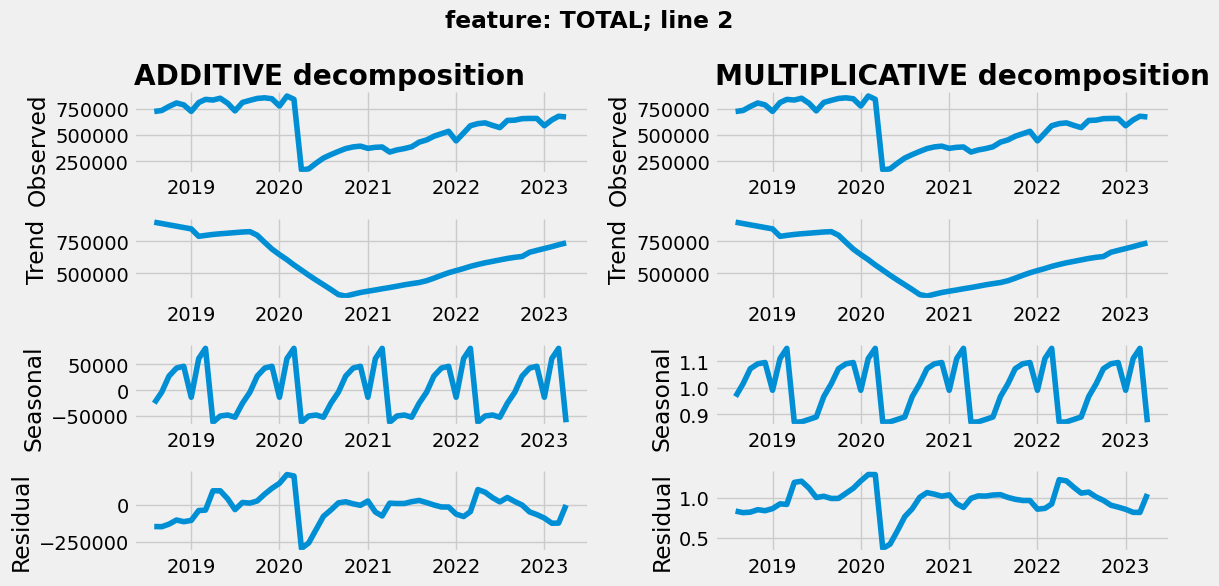

ADF test for stationarity on feature TOTAL and line 3
	p-value for residuals on additive decomposition       0.001
	p-value for residuals on multiplicative decomposition 0.000


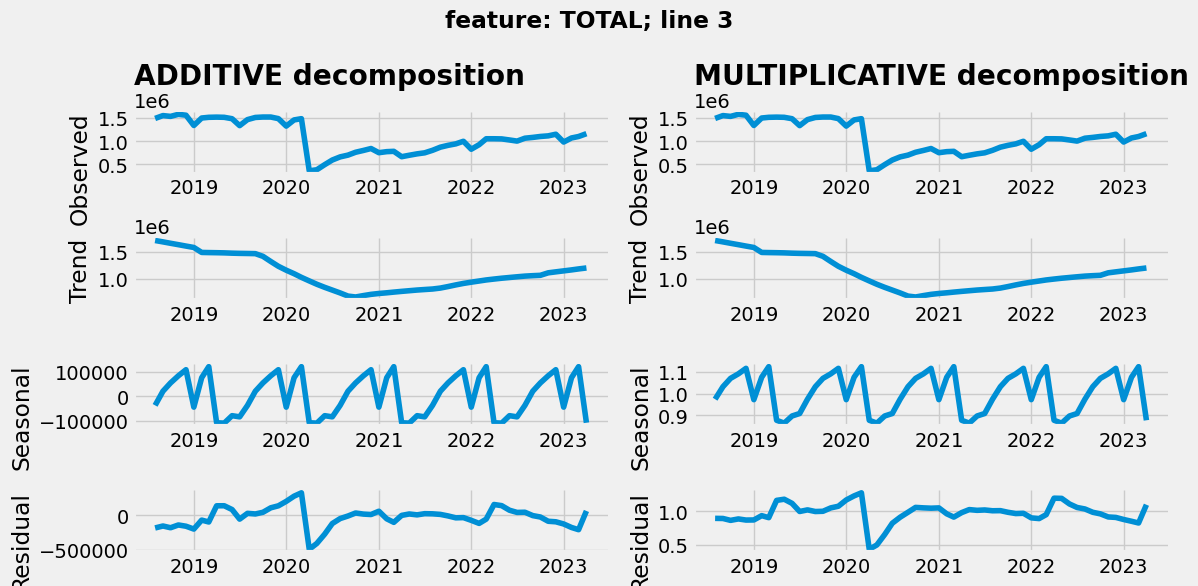

ADF test for stationarity on feature TOTAL and line 4
	p-value for residuals on additive decomposition       0.001
	p-value for residuals on multiplicative decomposition 0.000


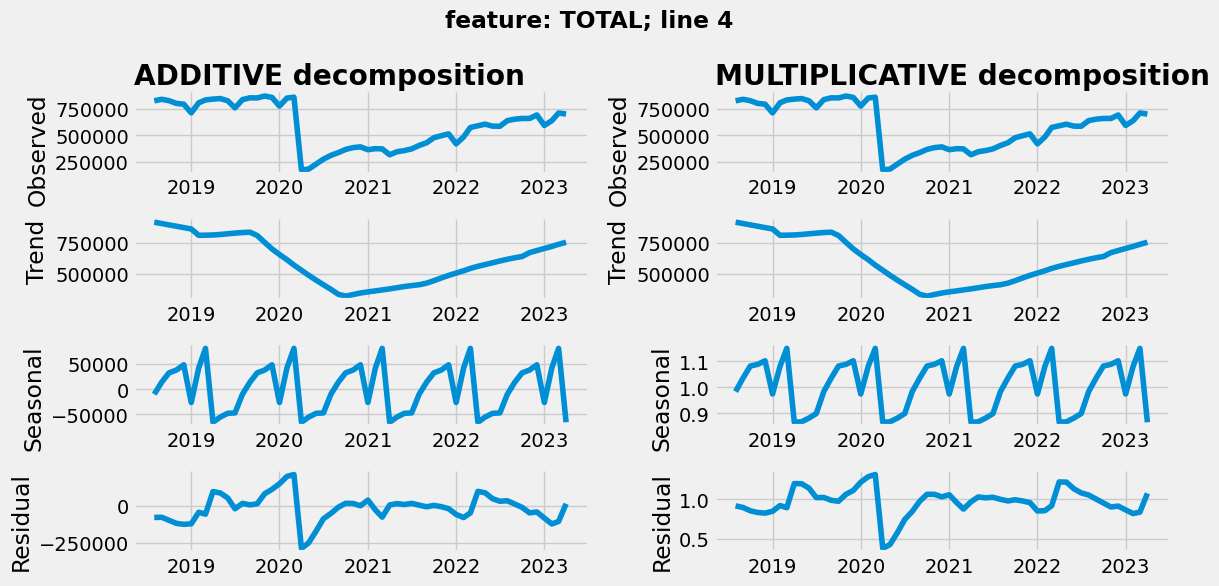

ADF test for stationarity on feature TOTAL and line 5
	p-value for residuals on additive decomposition       0.000
	p-value for residuals on multiplicative decomposition 0.000


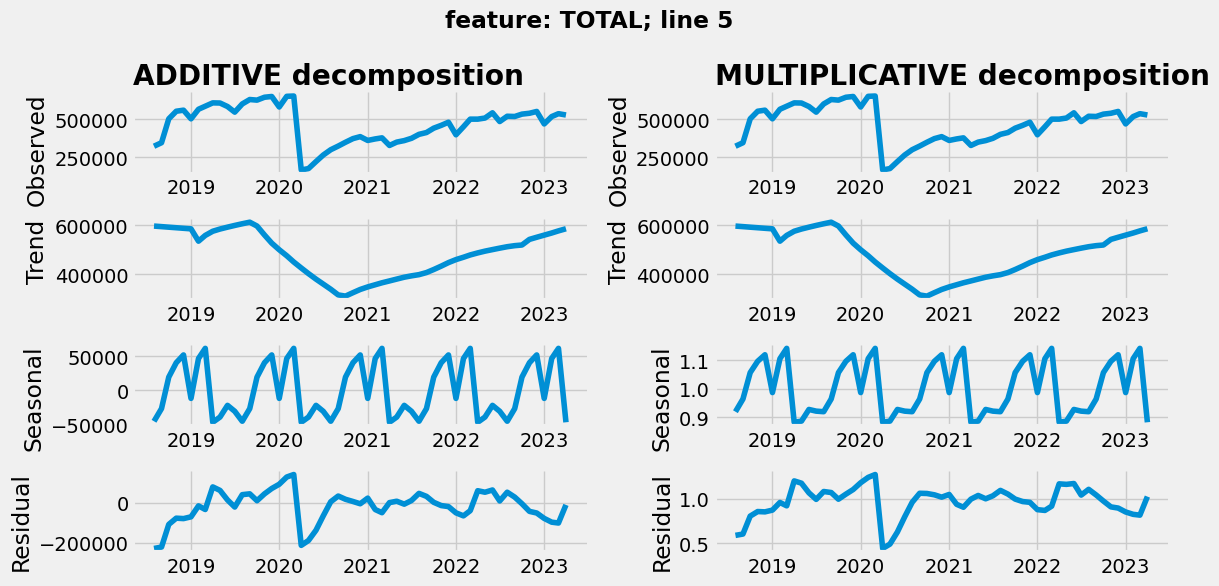

ADF test for stationarity on feature TOTAL and line 15
	p-value for residuals on additive decomposition       0.000
	p-value for residuals on multiplicative decomposition 0.000


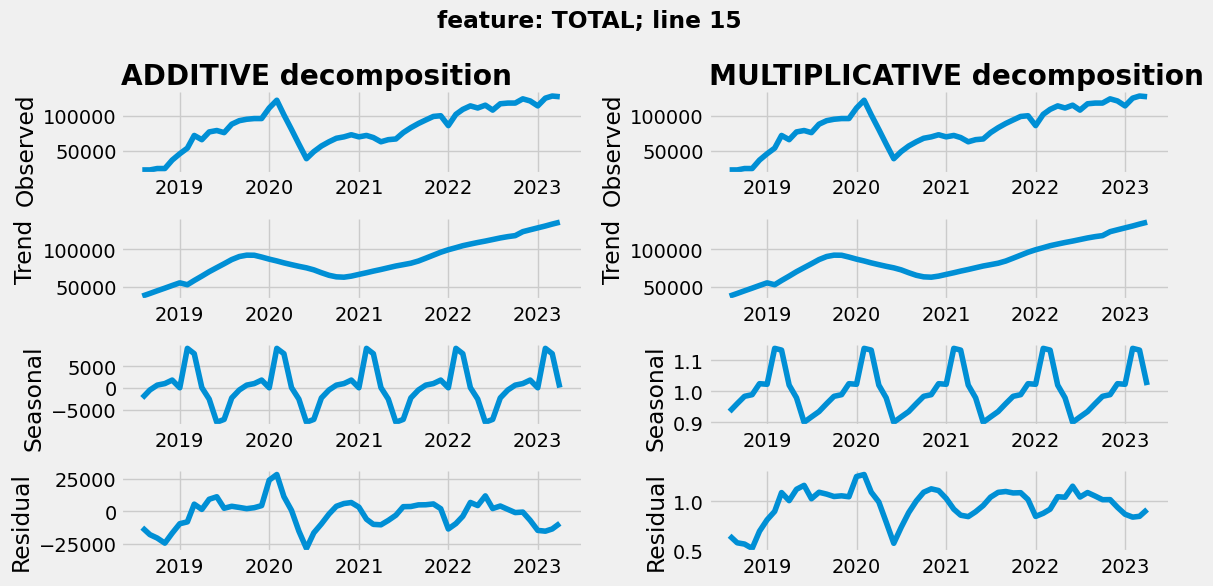

In [55]:
# get unique lines
unique_lines = df_train["line"].unique().tolist()
unique_lines.sort()

# iterate over available lines
for line in unique_lines:
    # filter to only a single line
    df_line = df_train.loc[df_train["line"] == line, ["year_month", col]]

    # create a new dataframe with year_month as index,
    # dropping year_month from column
    # and filling any missing data with linear interpolation
    df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
    # fill any missing data at the begining of dataset (not able to interpolate)
    # with backfill
    df_line = df_line.fillna(method="backfill")

    # Additive Decomposition (y = Trend + Seasonal + Residuals)
    result_add = seasonal_decompose(df_line[col], model='additive', extrapolate_trend = "freq")
    # Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
    result_mul = seasonal_decompose(df_line[col], model='multiplicative', extrapolate_trend = "freq")

    # print report about residual
    print(
        f"ADF test for stationarity on feature TOTAL and line {line}\n"
        # perform Augmented Dickey Fuller - ADF to check for stationarity
        # H0: The series is not-stationary
        f"\tp-value for residuals on additive decomposition       {adfuller(result_add.resid)[1]:.3f}\n"
        f"\tp-value for residuals on multiplicative decomposition {adfuller(result_mul.resid)[1]:.3f}"
    )
    # define plot details
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 6), tight_layout=True)
    # define figure title
    fig.suptitle(f"feature: TOTAL; line {line}")

    # iterate over seasonal decompositions
    for idx, sd in enumerate(zip([result_add, result_mul], ["additive", "multiplicative"])):
        # plot seasonal decomposition
        axs[0, idx].set_title(f"{sd[1].upper()} decomposition")
        axs[0, idx].plot(sd[0].observed)
        axs[0, idx].set_ylabel("Observed")
        axs[1, idx].plot(sd[0].trend)
        axs[1, idx].set_ylabel("Trend")
        axs[2, idx].plot(sd[0].seasonal)
        axs[2, idx].set_ylabel("Seasonal")
        axs[3, idx].plot(sd[0].resid)
        axs[3, idx].set_ylabel("Residual")

    # display image
    plt.show()

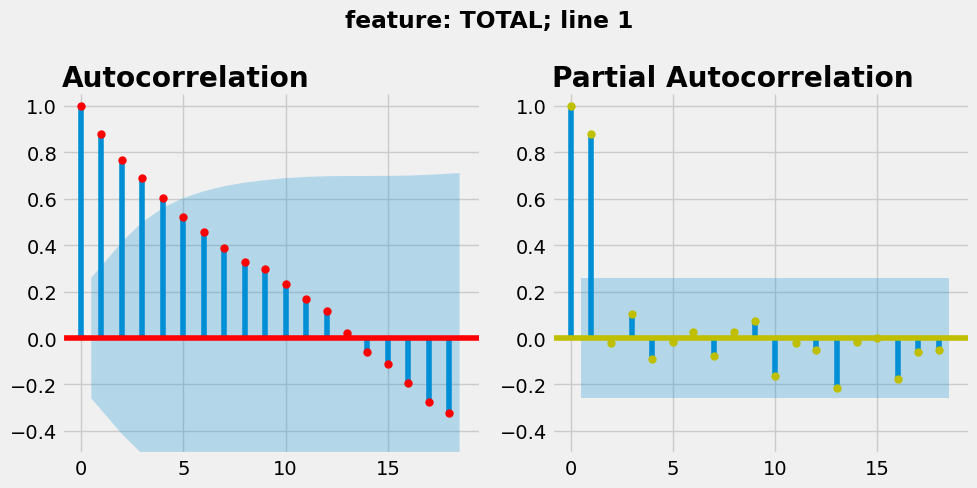

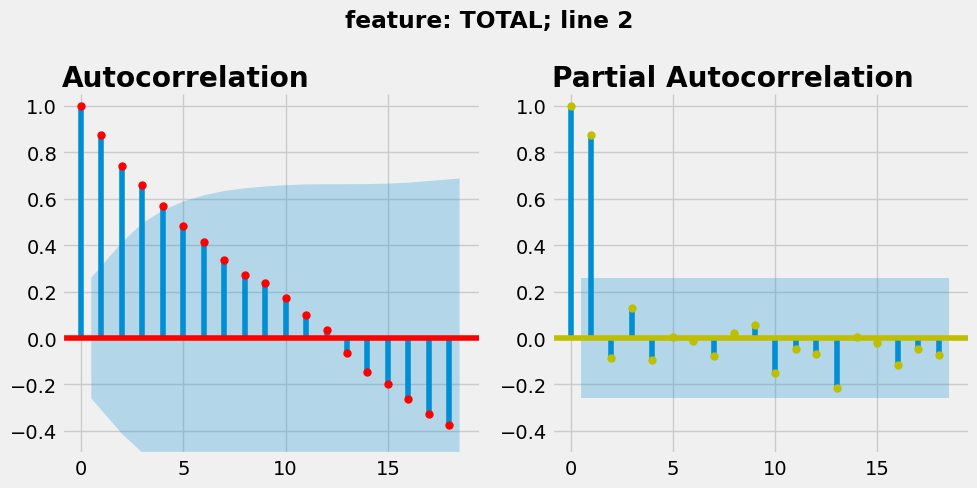

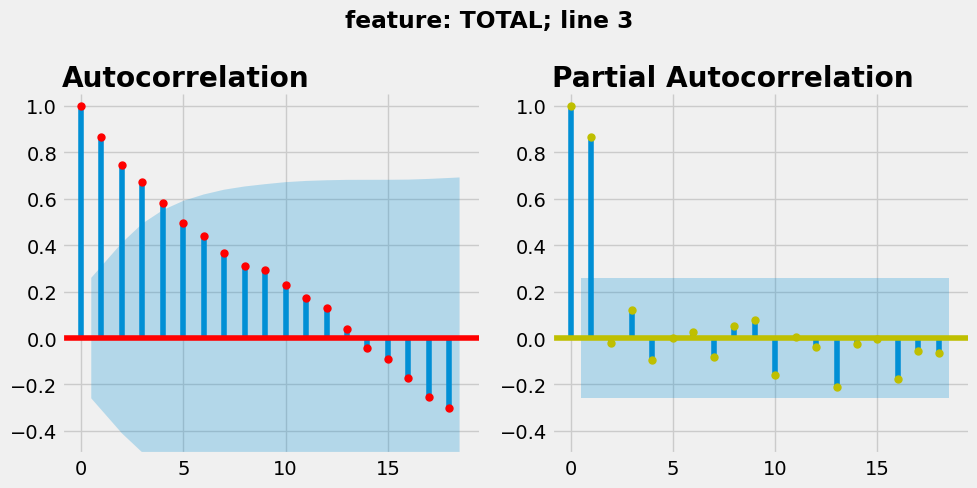

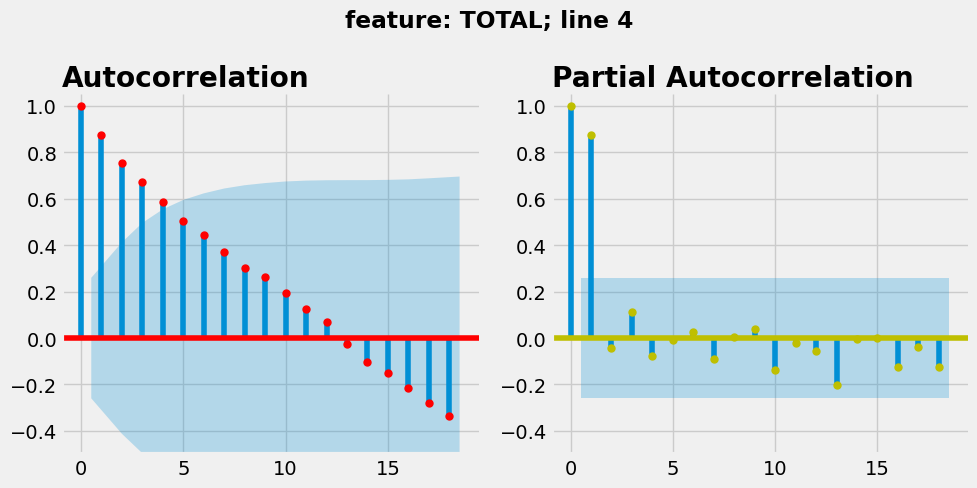

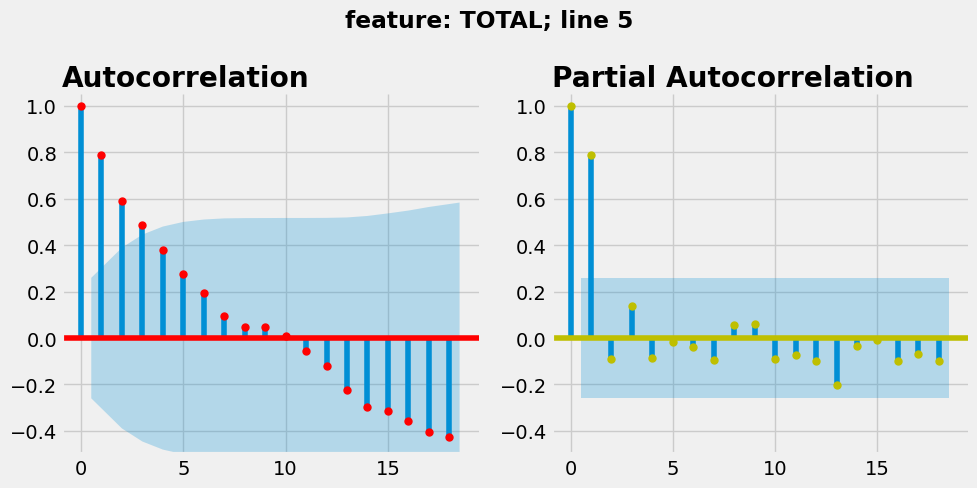

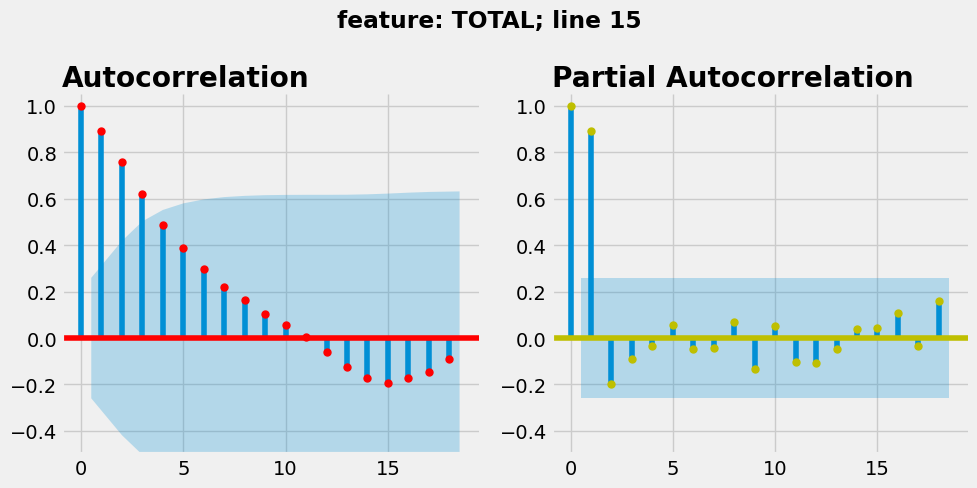

In [56]:
# get unique lines
unique_lines = df_train["line"].unique().tolist()
unique_lines.sort()

# iterate over available lines
for line in unique_lines:
    # filter to only a single line
    df_line = df_train.loc[df_train["line"] == line, ["year_month", col]]

    # create a new dataframe with year_month as index,
    # dropping year_month from column
    # and filling any missing data with linear interpolation
    df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
    # fill any missing data at the begining of dataset (not able to interpolate)
    # with backfill
    df_line = df_line.fillna(method="backfill")

    # define plot details
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), tight_layout=True)
    # define figure title
    fig.suptitle(f"feature: TOTAL; line {line}")

    # plot acf and padf
    plot_acf(df_line, c="r", zero=True, ax=axs[0])
    plot_pacf(df_line, c="y", zero=True, ax=axs[1])
    # plot details
    axs[0].set_ylim(-0.5, 1.05)
    axs[1].set_ylim(-0.5, 1.05)
    plt.show()

ARIMA

In summary, initial guess is:

    p = 1, q = 3, i = 0

In [57]:
# # define target column
# col = "total"

# # try to create experiment
# try:
#     # create MLFlow experiment
#     experiment_id = mlflow.create_experiment(
#         name="initial_time_series_experiment"
#         )
# # experiment already exist
# except mlflow.exceptions.MlflowException:
#     # create MLFlow experiment
#     experiment_id = mlflow.get_experiment_by_name(
#         name="initial_time_series_experiment"
#         ).experiment_id

# # get unique lines
# unique_lines = df_train["line"].unique().tolist()
# unique_lines.sort()

# # iterate over available lines
# for line in unique_lines:

#     # print report
#     print(f"On line {line} 🚀")

#     # filter to only a single line
#     df_model = df_train.loc[df_train["line"] == line, ["year_month", col]]

#     # create a new dataframe with year_month as index,
#     # dropping year_month from column
#     # and filling any missing data with linear interpolation
#     df_model = df_model.set_index("year_month", drop=True).interpolate(method="linear")
#     # fill any missing data at the begining of dataset (not able to interpolate)
#     # with backfill
#     df_model = df_model.fillna(method="backfill")

#     # define object to split data taking into account the order of dates
#     ts_cv = TimeSeriesSplit(n_splits=10, max_train_size=None, test_size=3, gap=0)

#     # create a dict to store performance over different k folds
#     perform_dict = {
#         "mape": [],
#         "mpe": [],
#         "mae": [],
#         "rmse": [],
#         "rmsle": []
#     }

#     # define training params
#     train_params = dict(
#         exog=None, 
#         order=(1, 0, 3), 
#         seasonal_order=(0, 0, 0, 0), 
#         # trend="ct", 
#         enforce_stationarity=True, 
#     )

#     # iterate over time series cv folds
#     for i, (train_index, test_index) in enumerate(ts_cv.split(df_model)):
#         # # print report
#         # print(f"Fold {i}:")

#         # sanity check
#         assert train_index.max() < test_index.min(), "Mix of dates between train and test!"

#         # split dataset
#         train = df_model.iloc[train_index]
#         test = df_model.iloc[test_index]
        
#         # define ARIMA model
#         arima = ARIMA(
#             endog=train, 
#             **train_params
#         )    

#         # catch warnings with context manager
#         with warnings.catch_warnings():
#             # import warning                 
#             from statsmodels.tools.sm_exceptions import ValueWarning
#             # ignore warning
#             warnings.filterwarnings(action='ignore', category=ValueWarning)
#             # fit model to data
#             arima = arima.fit()

#             # concatenate predictions and real values
#             df_forecast = pd.concat(objs=[arima.forecast(steps=3), test], axis=1, join="inner", ignore_index=False)

#         # get model results
#         performance = forecast_performance(forecast=df_forecast["predicted_mean"], actual=df_forecast["total"])

#         # iterate over metrics for kfolds
#         for k, v in performance.items():
#             # add metric to kfolds metrics
#             perform_dict[k].append(v)


#     # define MLFlow model tag
#     mlflow_model_tag = f"ARMA[line={line}]({train_params['order']})({train_params['seasonal_order']})"

#     # make a run on MLFlow with context manager
#     with mlflow.start_run(
#         experiment_id=experiment_id, 
#         run_name=mlflow_model_tag, 
#         tags={
#             "experiment_type": "time_series_forecasting",
#             "model": "ARMA"
#         }):

#         # select active run
#         run = mlflow.active_run()
#         # report run status
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")


#         # calculate mean performance metrics over all kfolds
#         perform_mean_dict = {k: np.mean(v) for k, v in perform_dict.items()}      

#         # log model name as param
#         mlflow.log_param("model", "ARMA")
#         # log metrics on MLFlow
#         mlflow.log_metrics(perform_mean_dict)
#         # log chosen model params
#         mlflow.log_params(train_params)

#         # log model
#         mlflow.sklearn.log_model(
#             sk_model=arima, # last arima model (with largest training dataset)
#             artifact_path="arma",
#             registered_model_name=(mlflow_model_tag + "_algo")
#             )

#         # end run and get status
#         mlflow.end_run()
#         run = mlflow.get_run(run.info.run_id)
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")

#         # print report
#         print(f"Successfully trained and logged ARMA on line {line} ✅\n")    

### ARIMA

ADF test for stationarity on feature TOTAL and line 1
	p-value for residuals on additive decomposition       0.000



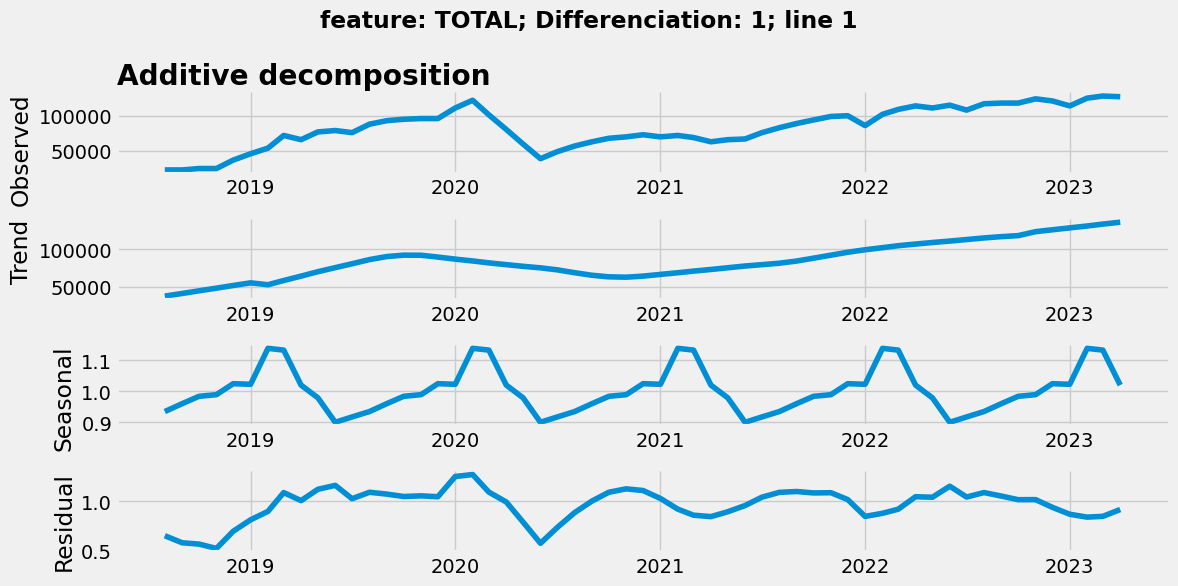

ADF test for stationarity on feature TOTAL and line 2
	p-value for residuals on additive decomposition       0.000



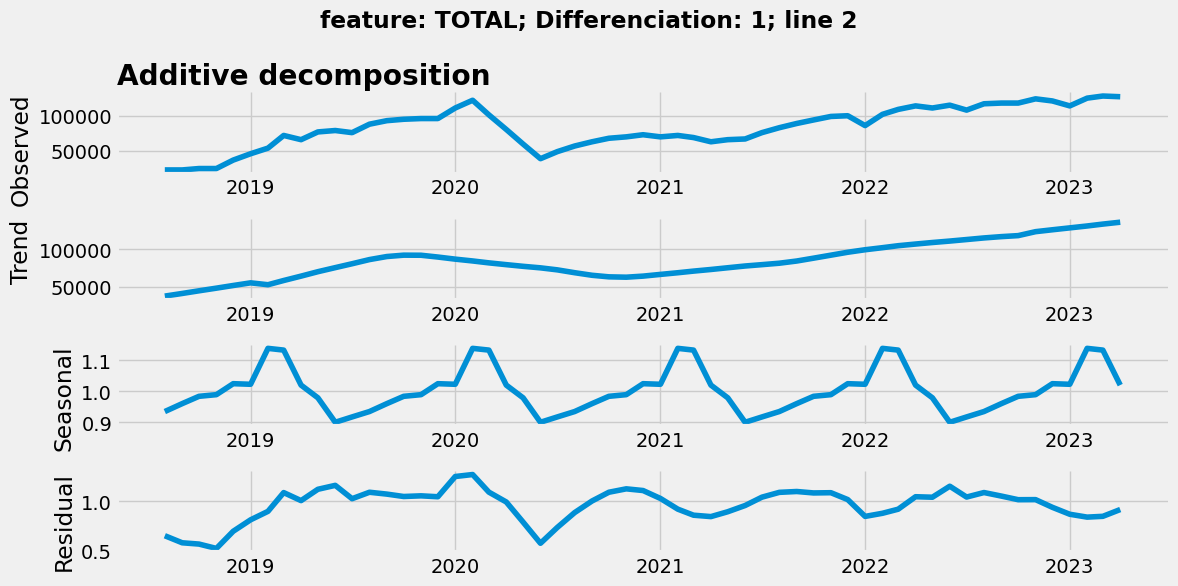

ADF test for stationarity on feature TOTAL and line 3
	p-value for residuals on additive decomposition       0.000



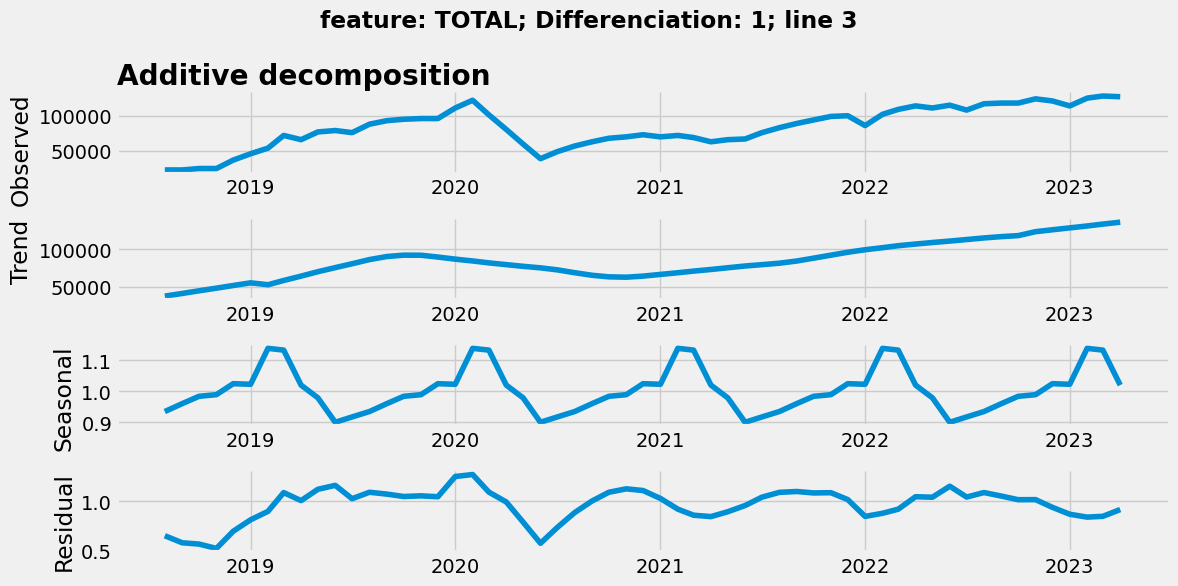

ADF test for stationarity on feature TOTAL and line 4
	p-value for residuals on additive decomposition       0.000



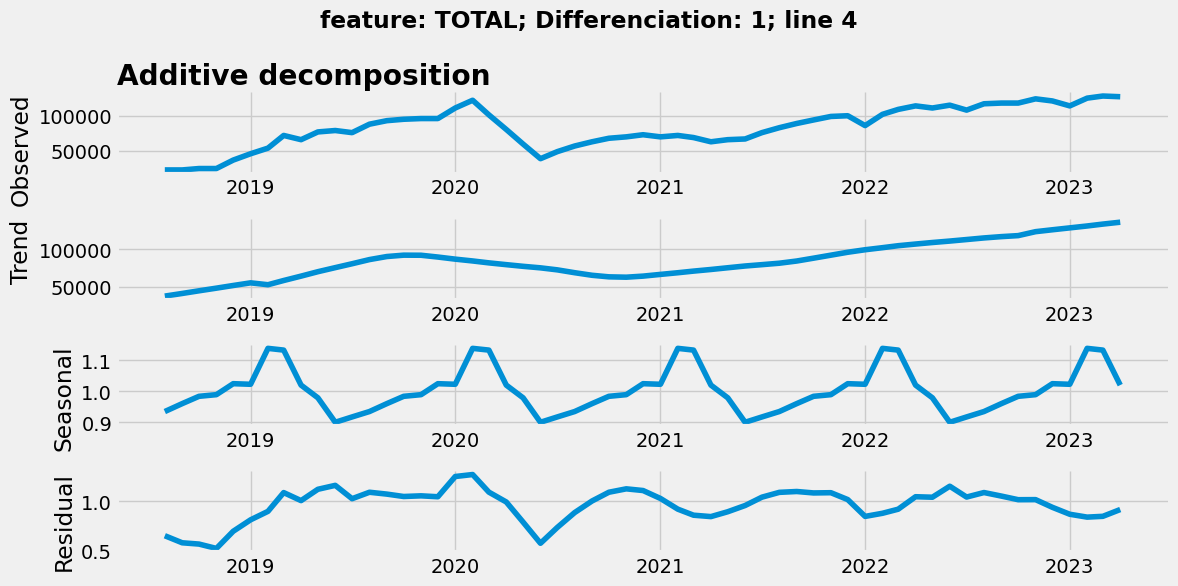

ADF test for stationarity on feature TOTAL and line 5
	p-value for residuals on additive decomposition       0.000



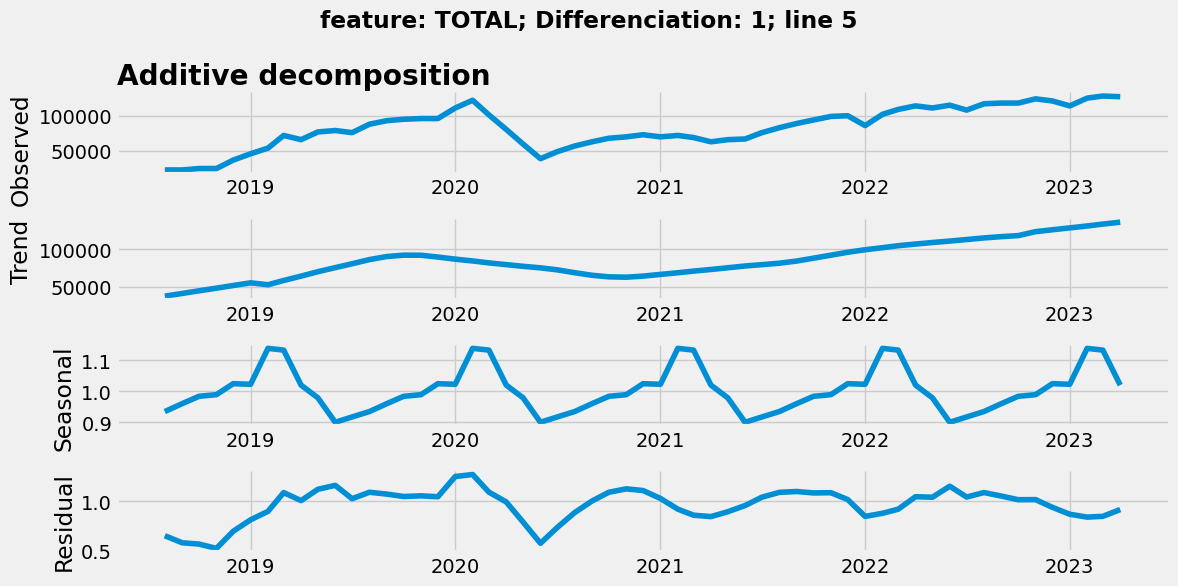

ADF test for stationarity on feature TOTAL and line 15
	p-value for residuals on additive decomposition       0.000



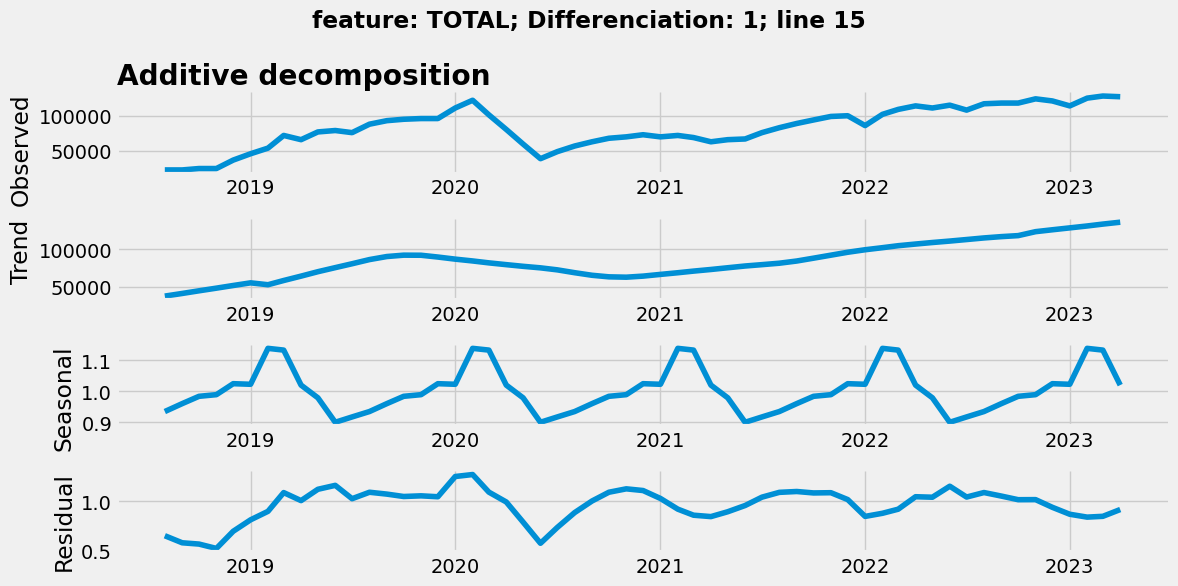

In [58]:
# get unique lines
unique_lines = df_train["line"].unique().tolist()
unique_lines.sort()

# iterate over available lines
for line in unique_lines:
    # filter to only a single line
    df_line = df_train.loc[df_train["line"] == line, ["year_month", col]]

    # create a new dataframe with year_month as index,
    # dropping year_month from column
    # and filling any missing data with linear interpolation
    df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
    # diferentiate time-series and remove any NAs
    df_line = df_line.diff(1).dropna(axis="index")
    
    # Additive Decomposition (y = Trend + Seasonal + Residuals)
    result_add = seasonal_decompose(df_line[col], model='additive', extrapolate_trend = "freq")
    # # Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
    # HOWEVER, multiplicative seasonality is not appropriate for zero and negative values
    # result_mul = seasonal_decompose(df_line[col], model='multiplicative', extrapolate_trend = "freq")

    # print report about residual
    print(
        f"ADF test for stationarity on feature TOTAL and line {line}\n"
        # perform Augmented Dickey Fuller - ADF to check for stationarity
        # H0: The series is not-stationary
        f"\tp-value for residuals on additive decomposition       {adfuller(result_add.resid)[1]:.3f}\n"
        # f"\tp-value for residuals on multiplicative decomposition {adfuller(result_mul.resid)[1]:.3f}"
    )
    # define plot details
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12, 6), tight_layout=True)
    # define figure title
    fig.suptitle(f"feature: TOTAL; Differenciation: 1; line {line}")

    # plot seasonal decomposition
    axs[0].set_title(f"Additive decomposition")
    axs[0].plot(sd[0].observed)
    axs[0].set_ylabel("Observed")
    axs[1].plot(sd[0].trend)
    axs[1].set_ylabel("Trend")
    axs[2].plot(sd[0].seasonal)
    axs[2].set_ylabel("Seasonal")
    axs[3].plot(sd[0].resid)
    axs[3].set_ylabel("Residual")

    # display image
    plt.show()

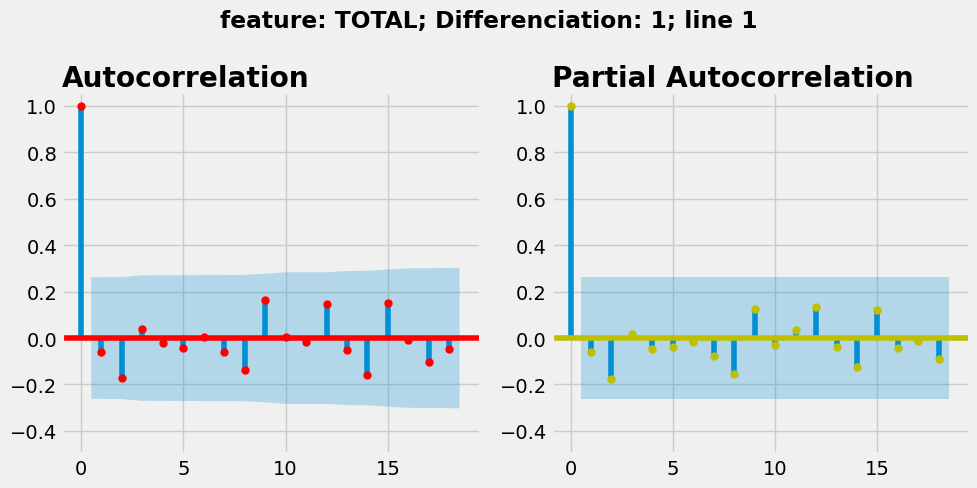

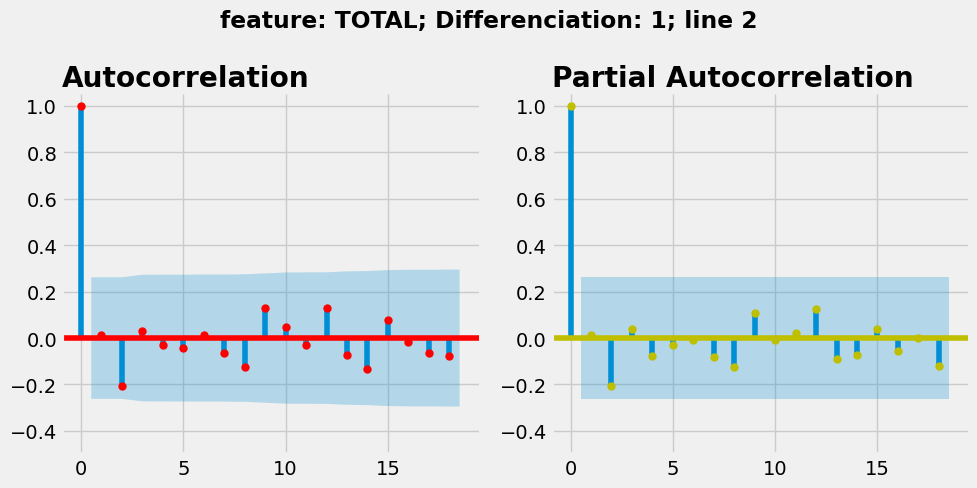

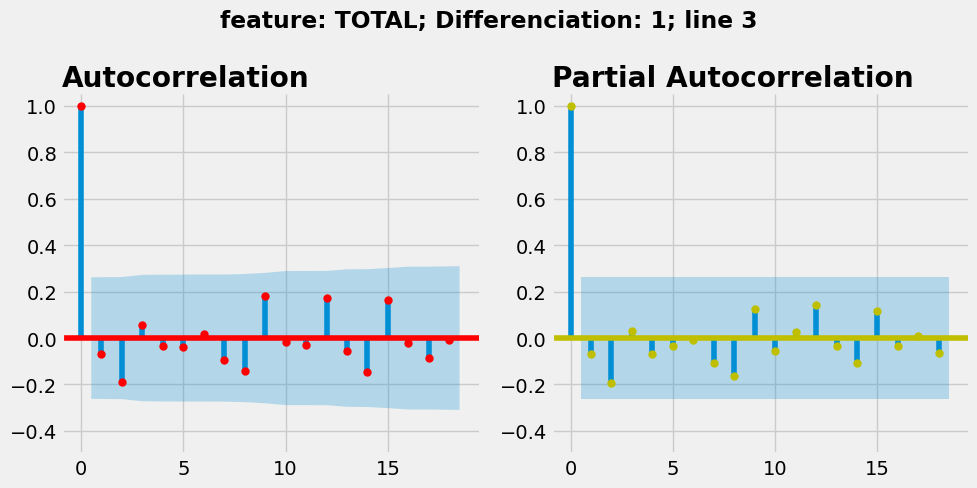

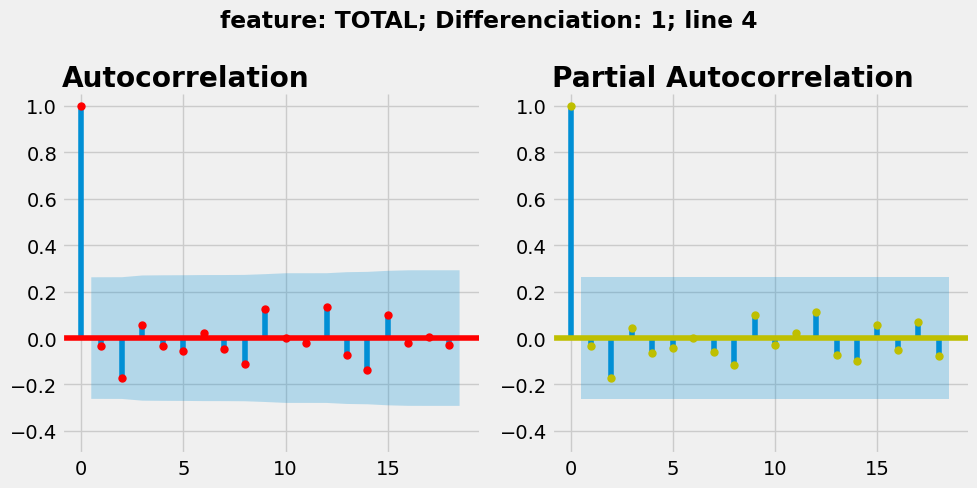

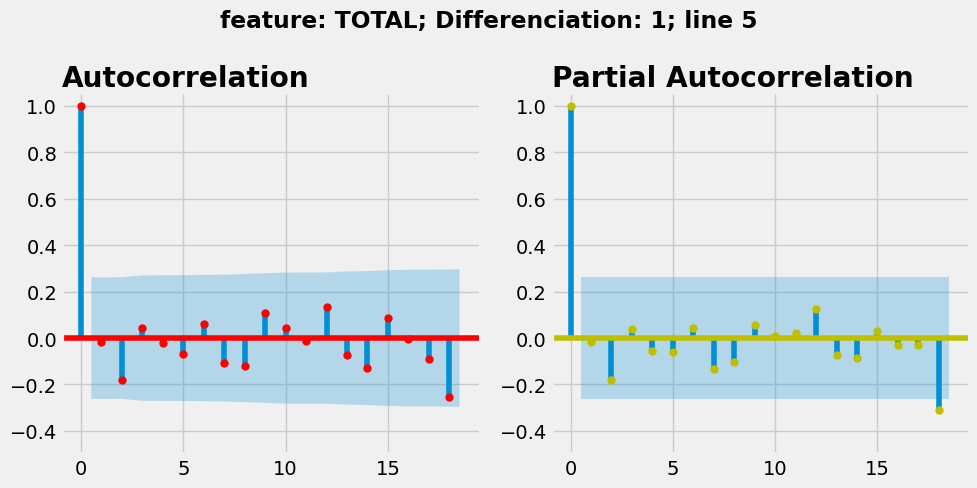

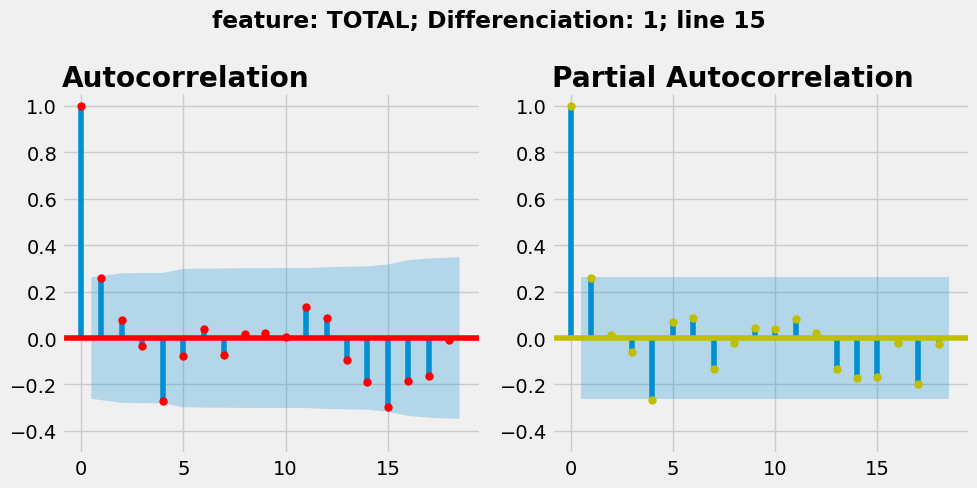

In [59]:
# get unique lines
unique_lines = df_train["line"].unique().tolist()
unique_lines.sort()

# iterate over available lines
for line in unique_lines:
    # filter to only a single line
    df_line = df_train.loc[df_train["line"] == line, ["year_month", col]]

    # create a new dataframe with year_month as index,
    # dropping year_month from column
    # and filling any missing data with linear interpolation
    df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
    # diferentiate time-series and remove any NAs
    df_line = df_line.diff(1).dropna(axis="index")

    # define plot details
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), tight_layout=True)
    # define figure title
    fig.suptitle(f"feature: TOTAL; Differenciation: 1; line {line}")

    # plot acf and padf
    plot_acf(df_line, c="r", zero=True, ax=axs[0])
    plot_pacf(df_line, c="y", zero=True, ax=axs[1])
    # plot details
    axs[0].set_ylim(-0.5, 1.05)
    axs[1].set_ylim(-0.5, 1.05)
    plt.show()

In [60]:
# # define target column
# col = "total"

# # try to create experiment
# try:
#     # create MLFlow experiment
#     experiment_id = mlflow.create_experiment(
#         name="initial_time_series_experiment"
#         )
# # experiment already exist
# except mlflow.exceptions.MlflowException:
#     # create MLFlow experiment
#     experiment_id = mlflow.get_experiment_by_name(
#         name="initial_time_series_experiment"
#         ).experiment_id

# # get unique lines
# unique_lines = df_train["line"].unique().tolist()
# unique_lines.sort()

# # iterate over available lines
# for line in unique_lines:

#     # print report
#     print(f"On line {line} 🚀")

#     # filter to only a single line
#     df_model = df_train.loc[df_train["line"] == line, ["year_month", col]]

#     # create a new dataframe with year_month as index,
#     # dropping year_month from column
#     # and filling any missing data with linear interpolation
#     df_model = df_model.set_index("year_month", drop=True).interpolate(method="linear")
#     # diferentiate time-series and remove any NAs
#     df_line = df_line.diff(1).dropna(axis="index")

#     # define object to split data taking into account the order of dates
#     ts_cv = TimeSeriesSplit(n_splits=10, max_train_size=None, test_size=3, gap=0)

#     # create a dict to store performance over different k folds
#     perform_dict = {
#         "mape": [],
#         "mpe": [],
#         "mae": [],
#         "rmse": [],
#         "rmsle": []
#     }

#     # define training params
#     train_params = dict(
#         exog=None, 
#         order=(0, 1, 0), 
#         seasonal_order=(0, 0, 0, 0), 
#         # trend="ct", 
#         enforce_stationarity=True, 
#     )

#     # iterate over time series cv folds
#     for i, (train_index, test_index) in enumerate(ts_cv.split(df_model)):
#         # # print report
#         # print(f"Fold {i}:")

#         # sanity check
#         assert train_index.max() < test_index.min(), "Mix of dates between train and test!"

#         # split dataset
#         train = df_model.iloc[train_index]
#         test = df_model.iloc[test_index]
        
#         # define ARIMA model
#         arima = ARIMA(
#             endog=train, 
#             **train_params
#         )    

#         # catch warnings with context manager
#         with warnings.catch_warnings():
#             # import warning                 
#             from statsmodels.tools.sm_exceptions import ValueWarning
#             # ignore warning
#             warnings.filterwarnings(action='ignore', category=ValueWarning)
#             # fit model to data
#             arima = arima.fit()

#             # concatenate predictions and real values
#             df_forecast = pd.concat(objs=[arima.forecast(steps=3), test], axis=1, join="inner", ignore_index=False)

#         # get model results
#         performance = forecast_performance(forecast=df_forecast["predicted_mean"], actual=df_forecast["total"])

#         # iterate over metrics for kfolds
#         for k, v in performance.items():
#             # add metric to kfolds metrics
#             perform_dict[k].append(v)


#     # define MLFlow model tag
#     mlflow_model_tag = f"ARIMA[line={line}]({train_params['order']})({train_params['seasonal_order']})"

#     # make a run on MLFlow with context manager
#     with mlflow.start_run(
#         experiment_id=experiment_id, 
#         run_name=mlflow_model_tag, 
#         tags={
#             "experiment_type": "time_series_forecasting",
#             "model": "ARIMA"
#         }):

#         # select active run
#         run = mlflow.active_run()
#         # report run status
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")


#         # calculate mean performance metrics over all kfolds
#         perform_mean_dict = {k: np.mean(v) for k, v in perform_dict.items()}      

#         # log model name as param
#         mlflow.log_param("model", "ARIMA")
#         # log metrics on MLFlow
#         mlflow.log_metrics(perform_mean_dict)
#         # log chosen model params
#         mlflow.log_params(train_params)

#         # log model
#         mlflow.sklearn.log_model(
#             sk_model=arima, # last arima model (with largest training dataset)
#             artifact_path="arima",
#             registered_model_name=(mlflow_model_tag + "_algo")
#             )

#         # end run and get status
#         mlflow.end_run()
#         run = mlflow.get_run(run.info.run_id)
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")

#         # print report
#         print(f"Successfully trained and logged ARIMA on line {line} ✅\n")    

### SARIMA

ADF test for stationarity on feature TOTAL and line 1
	p-value for residuals on additive decomposition       0.001
	p-value for residuals on multiplicative decomposition 0.000


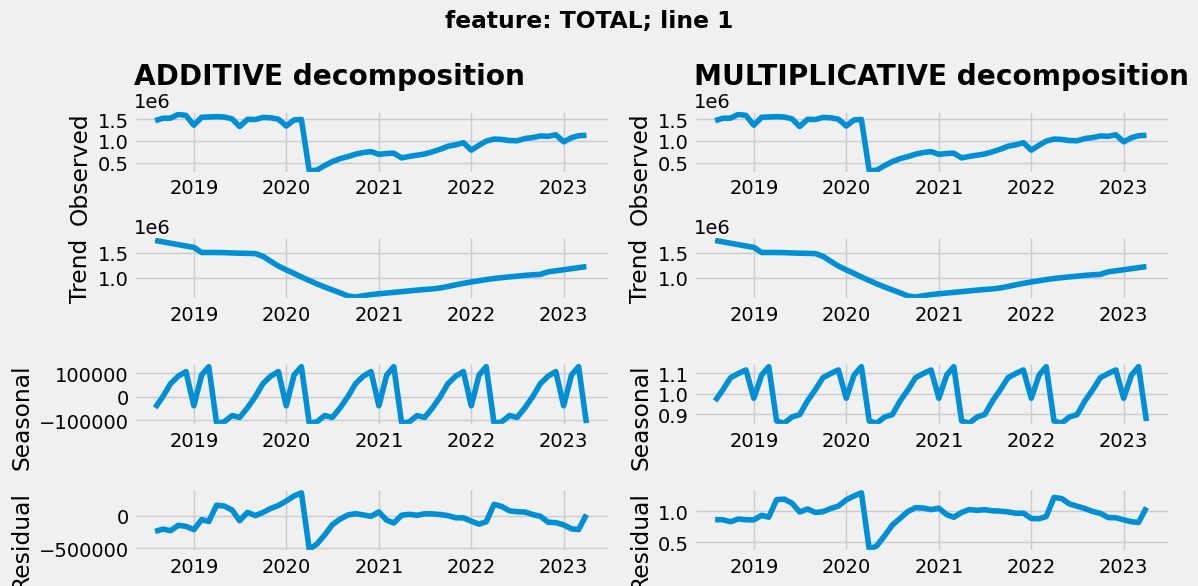

In [61]:
# define baseline line
line = 1 

# filter to only a single line
df_line = df_train.loc[df_train["line"] == line, ["year_month", col]]

# create a new dataframe with year_month as index,
# dropping year_month from column
# and filling any missing data with linear interpolation
df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
# fill any missing data at the begining of dataset (not able to interpolate)
# with backfill
df_line = df_line.fillna(method="backfill")

# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df_line[col], model='additive', extrapolate_trend = "freq")
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_mul = seasonal_decompose(df_line[col], model='multiplicative', extrapolate_trend = "freq")

# print report about residual
print(
    f"ADF test for stationarity on feature TOTAL and line {line}\n"
    # perform Augmented Dickey Fuller - ADF to check for stationarity
    # H0: The series is not-stationary
    f"\tp-value for residuals on additive decomposition       {adfuller(result_add.resid)[1]:.3f}\n"
    f"\tp-value for residuals on multiplicative decomposition {adfuller(result_mul.resid)[1]:.3f}"
)
# define plot details
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 6), tight_layout=True)
# define figure title
fig.suptitle(f"feature: TOTAL; line {line}")

# iterate over seasonal decompositions
for idx, sd in enumerate(zip([result_add, result_mul], ["additive", "multiplicative"])):
    # plot seasonal decomposition
    axs[0, idx].set_title(f"{sd[1].upper()} decomposition")
    axs[0, idx].plot(sd[0].observed)
    axs[0, idx].set_ylabel("Observed")
    axs[1, idx].plot(sd[0].trend)
    axs[1, idx].set_ylabel("Trend")
    axs[2, idx].plot(sd[0].seasonal)
    axs[2, idx].set_ylabel("Seasonal")
    axs[3, idx].plot(sd[0].resid)
    axs[3, idx].set_ylabel("Residual")

# display image
plt.show()

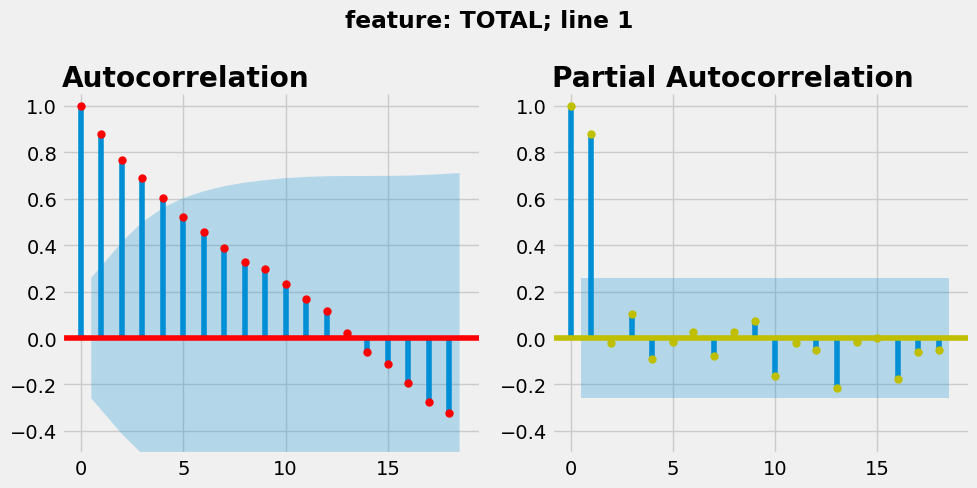

In [62]:
# define baseline line
line = 1 

# filter to only a single line
df_line = df_train.loc[df_train["line"] == line, ["year_month", col]]

# create a new dataframe with year_month as index,
# dropping year_month from column
# and filling any missing data with linear interpolation
df_line = df_line.set_index("year_month", drop=True).interpolate(method="linear")
# fill any missing data at the begining of dataset (not able to interpolate)
# with backfill
df_line = df_line.fillna(method="backfill")

# define plot details
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), tight_layout=True)
# define figure title
fig.suptitle(f"feature: TOTAL; line {line}")

# plot acf and padf
plot_acf(df_line, c="r", zero=True, ax=axs[0])
plot_pacf(df_line, c="y", zero=True, ax=axs[1])
# plot details
axs[0].set_ylim(-0.5, 1.05)
axs[1].set_ylim(-0.5, 1.05)
plt.show()

In [63]:
# define baseline line and col
line = 1
col = "total"

# filter to only a single line
df_model = df_train.loc[df_train["line"] == line, ["year_month", col]]

# create a new dataframe with year_month as index,
# dropping year_month from column
# and filling any missing data with linear interpolation
df_model = df_model.set_index("year_month", drop=True).interpolate(method="linear")
# fill any missing data at the begining of dataset (not able to interpolate)
# with backfill
df_model = df_model.fillna(method="backfill")

# inspect resutls
df_model.tail()

total
year_month               
2022-12-01 25,019,000.000
2023-01-01 23,408,000.000
2023-02-01 23,465,000.000
2023-03-01 27,945,000.000
2023-04-01 25,545,000.000

[5 rows x 1 columns]

In [64]:
# Define Auto-ARIMA to automatically discover the optimal order for an ARIMA model.
auto_model = pm.auto_arima(
    y=df_model["total"],
    start_p=0, max_p=2,
    d=0, max_d=1, 
    start_q=0, max_q=2,
    start_P=0, max_P=2, 
    D=1, max_D=1,
    start_Q=0, max_Q=2,
    max_order=5, 
    seasonal=True, m=12, # yearly seasonality
    trend=None, with_intercept="auto",
    #out_of_sample_size=7, 
    scoring="mae",
    trace=True, error_action="ignore", suppress_warnings=True, 
    n_jobs=-1
    )

# try to train model
try:
    # fit mode to data
    auto_model.fit()

# in case of type error    
except TypeError:
    pass

# regardless of errors
finally:
   # inspect results
    display(auto_model.summary())


/home/ds-gustavo-cunha/.pyenv/versions/omdena_sp_train/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1597.569, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1534.530, Time=0.70 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1565.957, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1599.112, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1552.513, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1518.006, Time=1.44 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1518.436, Time=2.39 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1521.983, Time=0.60 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1576.778, Time=0.40 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1520.305, Time=0.96 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1520.503, Time=0.77 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1562.864, Time=0.58 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1522.515, Time=2.28 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1516.090, Time=0.84 sec
 ARIMA(1,0,0)(1,1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   57
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -754.045
Date:                            Sat, 10 Jun 2023   AIC                           1516.090
Time:                                    16:41:17   BIC                           1523.317
Sample:                                08-01-2018   HQIC                          1518.784
                                     - 04-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5983      0.053     11.381      0.000       0.495       0.701
ar.S.L12      -0.4943      0.058     -8.465      0.000      -0.609      -0.380
ar.S.L24      -0.3781      0.052     -7.282      0.000      -0.480      -0.276
sigma2      2.082e+13   3.31e-16   6.29e+28      0.000    2.08e+13    2.08e+13
===================================================================================
Ljung-Box (L1) (Q):                   3.37   Jarque-Bera (JB):                14.14
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                            -1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.21e+44. Standard errors may be unstable.
"""

In [65]:
# check best params
auto_model.params

<bound method ARIMA.params of ARIMA(order=(1, 0, 0), scoring='mae', scoring_args={},
      seasonal_order=(2, 1, 0, 12), suppress_warnings=True,
      with_intercept=False)>

In [66]:
# # define target column
# col = "total"

# # try to create experiment
# try:
#     # create MLFlow experiment
#     experiment_id = mlflow.create_experiment(
#         name="initial_time_series_experiment"
#         )
# # experiment already exist
# except mlflow.exceptions.MlflowException:
#     # create MLFlow experiment
#     experiment_id = mlflow.get_experiment_by_name(
#         name="initial_time_series_experiment"
#         ).experiment_id

# # get unique lines
# unique_lines = df_train["line"].unique().tolist()
# unique_lines.sort()

# # iterate over available lines
# for line in unique_lines:

#     # print report
#     print(f"On line {line} 🚀")

#     # filter to only a single line
#     df_model = df_train.loc[df_train["line"] == line, ["year_month", col]]

#     # create a new dataframe with year_month as index,
#     # dropping year_month from column
#     # and filling any missing data with linear interpolation
#     df_model = df_model.set_index("year_month", drop=True).interpolate(method="linear")
#     # fill any missing data at the begining of dataset (not able to interpolate)
#     # with backfill
#     df_model = df_model.fillna(method="backfill")

#     # define object to split data taking into account the order of dates
#     ts_cv = TimeSeriesSplit(n_splits=10, max_train_size=None, test_size=3, gap=0)

#     # create a dict to store performance over different k folds
#     perform_dict = {
#         "mape": [],
#         "mpe": [],
#         "mae": [],
#         "rmse": [],
#         "rmsle": []
#     }

#     # define training params
#     train_params = dict(
#         exog=None, 
#         order=(1, 0, 0), 
#         seasonal_order=(2, 1, 0, 12), 
#         # trend="ct", 
#         enforce_stationarity=True, 
#     )

#     # iterate over time series cv folds
#     for i, (train_index, test_index) in enumerate(ts_cv.split(df_model)):
#         # # print report
#         # print(f"Fold {i}:")

#         # sanity check
#         assert train_index.max() < test_index.min(), "Mix of dates between train and test!"

#         # split dataset
#         train = df_model.iloc[train_index]
#         test = df_model.iloc[test_index]
        
#         # define ARIMA model
#         arima = ARIMA(
#             endog=train, 
#             **train_params
#         )    

#         # catch warnings with context manager
#         with warnings.catch_warnings():
#             # import warning                 
#             from statsmodels.tools.sm_exceptions import ValueWarning
#             # ignore warning
#             warnings.filterwarnings(action='ignore', category=ValueWarning)
#             # fit model to data
#             arima = arima.fit()

#             # concatenate predictions and real values
#             df_forecast = pd.concat(objs=[arima.forecast(steps=3), test], axis=1, join="inner", ignore_index=False)

#         # get model results
#         performance = forecast_performance(forecast=df_forecast["predicted_mean"], actual=df_forecast["total"])

#         # iterate over metrics for kfolds
#         for k, v in performance.items():
#             # add metric to kfolds metrics
#             perform_dict[k].append(v)


#     # define MLFlow model tag
#     mlflow_model_tag = f"SARIMA[line={line}]({train_params['order']})({train_params['seasonal_order']})"

#     # make a run on MLFlow with context manager
#     with mlflow.start_run(
#         experiment_id=experiment_id, 
#         run_name=mlflow_model_tag, 
#         tags={
#             "experiment_type": "time_series_forecasting",
#             "model": "SARIMA"
#         }):

#         # select active run
#         run = mlflow.active_run()
#         # report run status
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")


#         # calculate mean performance metrics over all kfolds
#         perform_mean_dict = {k: np.mean(v) for k, v in perform_dict.items()}      

#         # log model name as param
#         mlflow.log_param("model", "SARIMA")
#         # log metrics on MLFlow
#         mlflow.log_metrics(perform_mean_dict)
#         # log chosen model params
#         mlflow.log_params(train_params)

#         # log model
#         mlflow.sklearn.log_model(
#             sk_model=arima, # last arima model (with largest training dataset)
#             artifact_path="sarima",
#             registered_model_name=(mlflow_model_tag + "_algo")
#             )

#         # end run and get status
#         mlflow.end_run()
#         run = mlflow.get_run(run.info.run_id)
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")

#         # print report
#         print(f"Successfully trained and logged SARIMA on line {line} ✅\n")    

### ARMA & ARIMA & SARIMA experiments summary

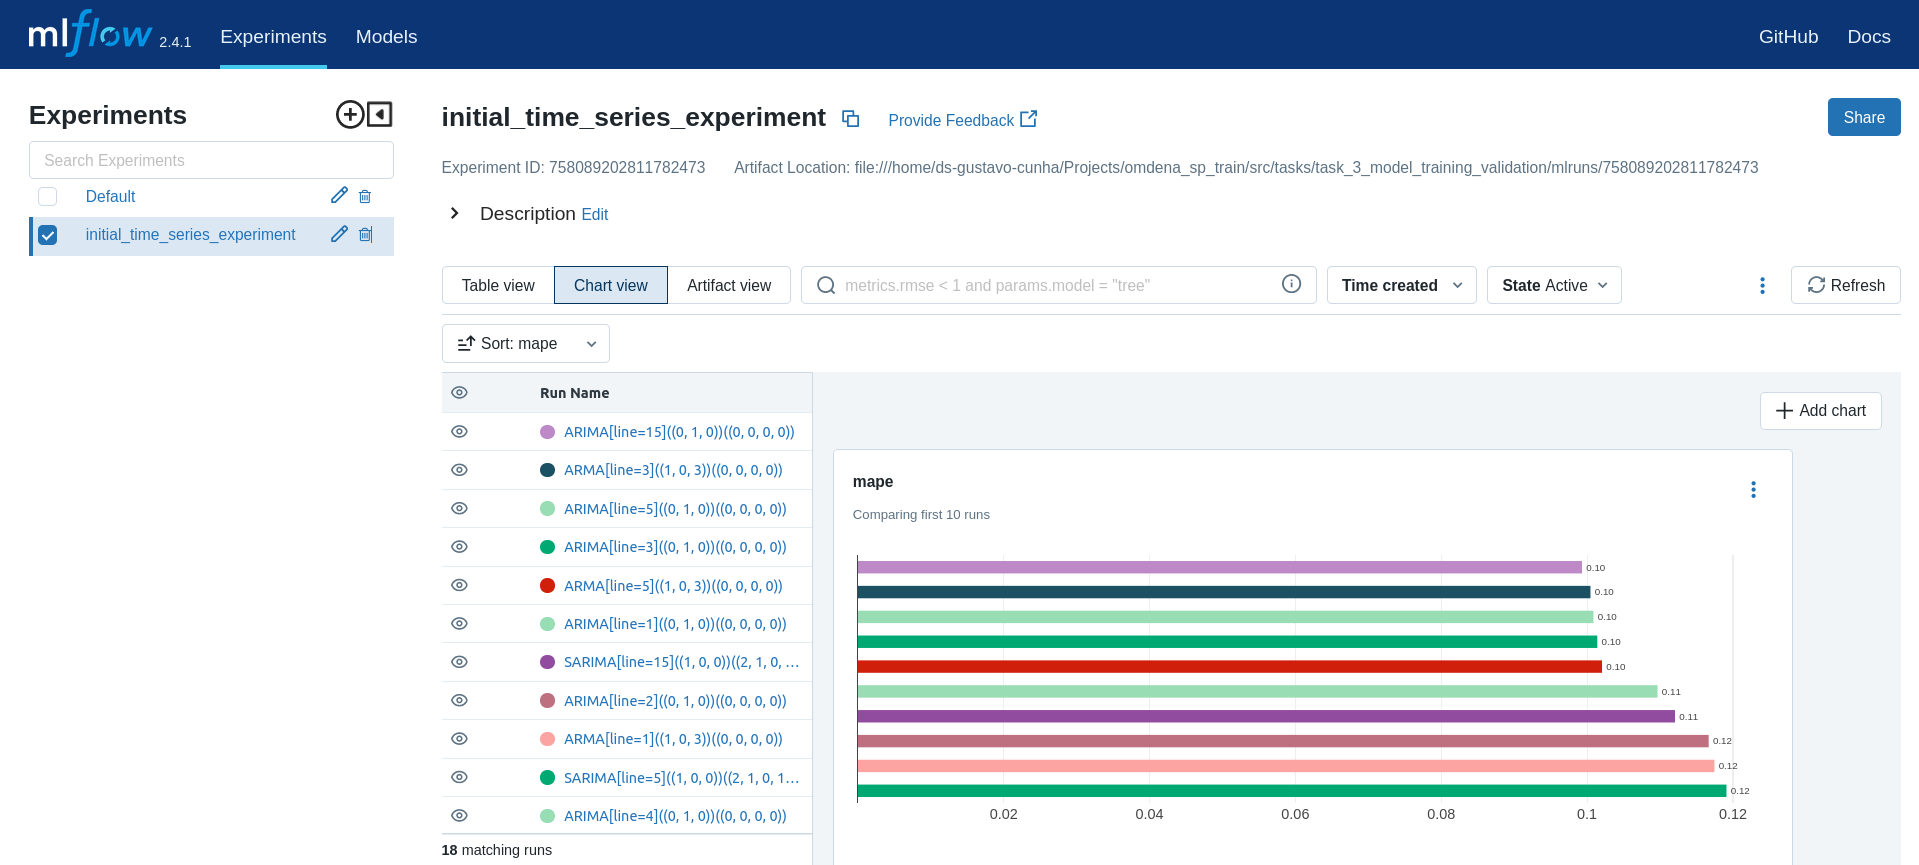

In [2]:
# load MLFlow print
Image.open("./mlflow_prints/(s)ar(i)ma_experiments.png")

### Prophet

## 8.5 - Final modelling comparison

*Compare all models and decide what one is the best (and will be fine-tuned)*

# **9 - HYPERPARAMETER TUNNING**

## 9.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [69]:
# create a restore point for the previous section dataframe
df_tune = df_train.copy()

# check dataframe
df_tune

## 9.2 - Hypertune the best ML model

*Check the best hyperparams for the best ML model*

### 9.2.1 - Grid Search

In [ ]:
# TO-DO

### 9.2.2 - Random Search

In [ ]:
# TO-DO

### 9.2.3 - Bayesian Search

In [ ]:
# TO-DO

## 9.3 - Define best hyperparameters

*Explicitly define best hyper parameters*

In [ ]:
# TO-DO

# **10 - PERFORMANCE EVALUATION AND INTERPRETATION**

## 10.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [ ]:
# create a restore point for the previous section dataframe
df_perform = df_tune.copy()

# check dataframe
df_perform

## 10.2 - Training Performance

*Get final model performance on training data*

In [ ]:
# TO-DO

## 10.3 - Generalization performance

### 10.3.1 - Final model training

*Get final model performance on validation data*

In [ ]:
# TO-DO

### 10.3.2 - Error analysis

*Perform error analysis on final model to make sure it is ready for production*

In [ ]:
# TO-DO

## 10.4 - Define prodution model

*Train ML on "training + validation" data*

In [ ]:
# TO-DO

## 10.5 - Testing performance

*Get production model performance on testing data*

In [ ]:
# TO-DO

## 10.6 - Business performance

*Translate testing performance into business results*

In [ ]:
# TO-DO

# **11 - DEPLOYMENT**

![Deployment architecture](../img/....jpg)

## 11.1 - API creation

*Code to create API for ML predictions*

In [ ]:
# TO-DO

## 11.2 - Docker container

*Code to create a Docker container and deploy ML model*

In [ ]:
# TO-DO